W1204 23:22:08.139348  389966 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1204 23:22:08.145401  389881 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Plotting initial state...


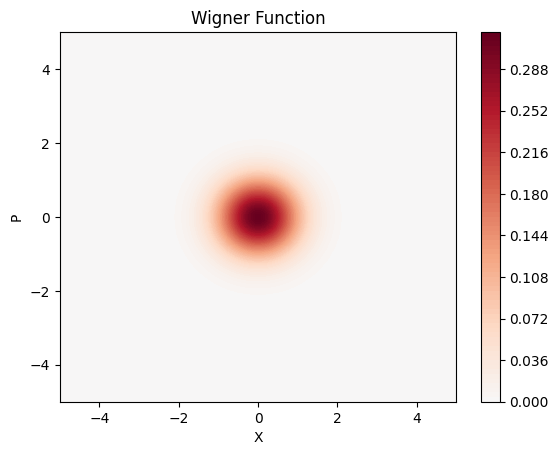

Starting integration (DOP853) from t=0.0 to 20...


KeyboardInterrupt: 

In [1]:
import jax.numpy as jnp
import jax.numpy.linalg as jla
import jax
import jax.scipy.linalg as jsl
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
from typing import Union, Tuple, Iterator
import fractions
import itertools
import functools
import math
import numpy as np
from scipy.integrate import solve_ivp # Import Scipy integrator

import jax
import jax.numpy as jnp
from jax.experimental import jet

jax.config.update("jax_enable_x64", True)

Rational = Union[int, fractions.Fraction]

# --- [Existing Math Helper Functions Remain Unchanged] ---

@functools.lru_cache(maxsize=None)
def binomial_coeff(n: Rational, k: int) -> Rational:
    if k < 0:
        raise ValueError("k must be a non-negative integer")
    n = fractions.Fraction(n)
    result = 1
    for i in range(k):
        result *= (n - i) / (i + 1)
    return result

MultiIndex = Tuple[int, ...]

def multi_index_lte(i: MultiIndex) -> Iterator[MultiIndex]:
    return itertools.islice(
        itertools.product(*(range(0, k + 1) for k in i)),
        1,
        None,
    )

@functools.lru_cache(maxsize=None)
def multi_index_binomial_coeff(i: Tuple[Rational, ...],
                               j: MultiIndex) -> Rational:
    result = 1
    for i_k, j_k in zip(i, j):
        result *= binomial_coeff(i_k, j_k)
    return result

def coeffs(i: MultiIndex) -> Iterator[Tuple[MultiIndex, Rational]]:
    for j in multi_index_lte(i):
        c = multi_index_binomial_coeff(i, j) * (-1)**(sum(i) - sum(j))
        if c != 0:
            yield j, c

@functools.lru_cache(maxsize=None)
def precompute_kc(orders: MultiIndex) -> Tuple[np.ndarray, np.ndarray]:
    ks, cs = [], []
    for k, c in coeffs(orders):
        k = np.array(list(map(float, k)))
        c = float(c)
        ks.append(list(k))
        cs.append(c)
    ks = np.array(ks)
    cs = np.array(cs)
    return ks, cs

def mixed_partial(f, orders: MultiIndex):
    d = sum(orders)
    ks, cs = precompute_kc(orders)
    dfact = math.factorial(d)

    def partial_der(x0):
        @jax.vmap
        def jetter(j):
            hs = (j, ) + (jnp.zeros_like(x0), ) * (d - 1)
            _, (*_, res) = jet.jet(f, (x0, ), (hs, ),)
            return res
        return jnp.sum(jetter(ks) * cs) / dfact
    return partial_der

# --- [Physical Constants and Model Definition] ---

G = .3 + .3j
delta = .1
U = .1
gamma = 1

def calculate_covariance(covariance_params):
    x, y, phi = covariance_params
    R = jnp.array([
        [jnp.cos(phi), -jnp.sin(phi)],
        [jnp.sin(phi), jnp.cos(phi)]
    ])
    S = jnp.array([
        [jnp.exp(x), 0],
        [0, jnp.exp(y)]
    ])
    Sigma = R@S@S@R.T
    return Sigma

def unwrap_params(params):
    normalization = params[0]
    mean = params[1:5]
    covariance_params = params[5:8]
    return normalization, mean, covariance_params

def generating_function(params_a, params_b, Js):
    normalization_a, mean_a, covariance_params_a = unwrap_params(params_a)
    normalization_b, mean_b, covariance_params_b = unwrap_params(params_b)
    alpha_a, beta_a = mean_a[::2], mean_a[1::2]
    alpha_b, beta_b =  mean_b[::2], mean_b[1::2]
    J, J_tilde = Js[:Js.size//2], Js[Js.size//2:]
    
    M_modes = 1
    covariance_a = calculate_covariance(covariance_params_a)
    covariance_b = calculate_covariance(covariance_params_b)
    
    covariance_sum = covariance_a + covariance_b
    covariance_sum_inv = jla.inv(covariance_sum)
    
    v1 = alpha_b - alpha_a - jnp.dot(covariance_a, J) - J_tilde
    inv_sigma_sum_v1 = jnp.dot(covariance_sum_inv, v1)
    
    diff_beta = beta_b - beta_a
    sum_beta = beta_b + beta_a
    inv_sigma_sum_diff_beta = jnp.dot(covariance_sum_inv, diff_beta)
    inv_sigma_sum_sum_beta = jnp.dot(covariance_sum_inv, sum_beta)

    Z1 = jnp.exp(-0.5 * jnp.dot(v1, inv_sigma_sum_v1))
    M_minus = jnp.exp(0.5 * jnp.dot(diff_beta, inv_sigma_sum_diff_beta))
    M_plus = jnp.exp(0.5 * jnp.dot(sum_beta, inv_sigma_sum_sum_beta))
    
    J_dot_beta = jnp.dot(J, beta_a)
    mix_term_minus = jnp.dot(diff_beta, inv_sigma_sum_v1)
    mix_term_plus = jnp.dot(sum_beta, inv_sigma_sum_v1)
    
    C_minus = jnp.cos(J_dot_beta - mix_term_minus)
    C_plus = jnp.cos(J_dot_beta + mix_term_plus)
    num_exponent = 0.5 * jnp.dot(J, jnp.dot(covariance_a, J)) + jnp.dot(J, alpha_a)
    
    sign, logdet = jnp.linalg.slogdet(covariance_sum)
    log_denominator = 0.5 * (2*M_modes * jnp.log(2 * jnp.pi) + logdet)
    prefactor = 0.5 * jnp.exp(num_exponent - log_denominator)
    
    return normalization_a*normalization_b*prefactor * Z1 * (M_minus * C_minus + M_plus * C_plus)

@jax.jit
def geometric_tensor(params):
    def total_gen_func(params_a, params_b):
        params_a = params_a.at[:,0].set(params_a[:,0]**2/jnp.sum(params_a[:,0]**2))
        params_b = params_b.at[:,0].set(params_b[:,0]**2/jnp.sum(params_b[:,0]**2))
        return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: generating_function(param_a, param_b, jnp.zeros((4))))(params_a))(params_b))
    return jax.jacfwd(jax.grad(total_gen_func, argnums=(1)), argnums=(0))(params, params).reshape(params.size, params.size)

def g(param_a, param_b, orders):
    if sum(orders) == 0:
        return generating_function(param_a, param_b, jnp.zeros((4)))
    g_f = partial(generating_function, param_a, param_b)
    return mixed_partial(g_f, orders)(jnp.zeros((4)))

def g_term(param_a, param_b):
    real_term = jnp.real(G)*(g(param_a, param_b,(0,1,1,0))+g(param_a, param_b,(1,0,0,1)))
    imag_term = jnp.imag(G)*(g(param_a, param_b,(1,0,1,0))-g(param_a, param_b,(0,1,0,1)))
    return real_term - imag_term

def delta_term(param_a, param_b):
    return delta*(g(param_a, param_b,(0,1,1,0))-g(param_a, param_b,(1,0,0,1)))

def u_term(param_a, param_b):
    total = g(param_a, param_b, (3,0,0,1)) 
    total += g(param_a, param_b, (1,2,0,1)) 
    total += -g(param_a, param_b, (2,1,1,0))
    total += -g(param_a, param_b, (0,3,1,0))
    total += 2*g(param_a, param_b, (0,1,1,0))
    total += -2*g(param_a, param_b, (1,0,0,1))
    total += 0.25*g(param_a, param_b, (0,1,3,0))
    total += -0.25*g(param_a, param_b, (1,0,0,3))
    total += -0.25*g(param_a, param_b, (1,0,2,1))
    total += 0.25*g(param_a, param_b, (0,1,1,2))
    return U/2*total

def single_photon_loss_term(param_a, param_b):
    total = g(param_a, param_b, (1, 0, 1, 0))
    total += g(param_a, param_b, (0, 1, 0, 1))
    total += 2*g(param_a, param_b, (0, 0, 0, 0))
    total += 0.5*g(param_a, param_b, (0,0,2,0))
    total += 0.5*g(param_a, param_b, (0,0,0,2))
    return gamma/2*total

def all_terms(params_a, params_b):
    params_a = params_a.at[:,0].set(params_a[:,0]**2/jnp.sum(params_a[:,0]**2))
    params_b = params_b.at[:,0].set(params_b[:,0]**2/jnp.sum(params_b[:,0]**2))
    def func(param_a, param_b):
        return g_term(param_a, param_b) + delta_term(param_a, param_b) + u_term(param_a, param_b) + single_photon_loss_term(param_a, param_b)
    return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: func(param_a, param_b))(params_b))(params_a))

@jax.jit
def liouvillian_gradient(params):
    return jax.grad(all_terms, argnums=0) (params, params)

@jax.jit
def number_operator(params):
    params = params.at[:,0].set(params[:,0]**2/jnp.sum(params[:,0]**2))

    # Vectorized helper for number operator within vmap
    def single_param_n(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2]
        return normalization*(jnp.sum(jnp.abs(mean)**2)+covariance[0,0]+covariance[1,1]-1)/2
    
    return jnp.sum(jax.vmap(single_param_n)(params))

@jax.jit
def parity_operator(params):
    # Vectorized helper for parity operator within vmap
    params = params.at[:,0].set(params[:,0]**2/jnp.sum(params[:,0]**2))
    def single_param_parity(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2] # Used in original, but math below uses real vector mean
        # Note: Original code had -mean. 
        # exp(-0.5 * (-mean) @ inv(cov) @ (-mean)) is same as exp(-0.5 * mean @ inv(cov) @ mean)
        term = jnp.exp(-0.5 * jnp.dot(-mean, jnp.dot(jla.inv(covariance), -mean)))
        return jnp.pi * normalization * jnp.real(term) / jnp.sqrt((2*jnp.pi)**2 * jnp.linalg.det(covariance))

    return jnp.sum(jax.vmap(single_param_parity)(params))

def plot_wigner(params):
    x = jnp.linspace(-5, 5, 100)
    p = jnp.linspace(-5, 5, 100)
    X, P = jnp.meshgrid(x, p)
    W = jnp.zeros(X.shape)
    
    # We can keep the loop here as visualization is not the bottleneck
    # or vectorize it if needed, but loop is fine for plotting at start/end
    for param in params:
        normalization, mean, covariance_params = unwrap_params(param)
        covariance = calculate_covariance(covariance_params)
        det_cov = jla.det(covariance)
        inv_cov = jla.inv(covariance)
        phase_vars = jnp.array([X.flatten(), P.flatten()]).T
        mean = mean[::2]+ 1j* mean[1::2]
        diff = phase_vars - mean
        exponent = -0.5 * jnp.einsum("ij,ij->i", jnp.dot(diff, inv_cov), diff)
        exponent = exponent.reshape(X.shape)
        W += normalization/(2*jnp.pi*jnp.sqrt(det_cov)) * jnp.real(jnp.exp(exponent))
        
    norm = matplotlib.colors.Normalize(-abs(W).max(), abs(W).max())
    plt.figure()
    plt.contourf(X, P, W, levels=100, cmap='RdBu_r', norm=norm)
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('P')
    plt.title('Wigner Function')
    plt.show()

# --- [Initialization Functions] ---

def initialize_cat_state(alpha=1.0):
    N_G = 4
    params = jnp.zeros((N_G, 8))
    weights = jnp.ones(N_G) 
    params = params.at[:, 0].set(weights)
    params = params.at[2:, 0].set(jnp.exp(-2 * (alpha)**2))
    
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0)
    
    dist = jnp.sqrt(2) * alpha
    params = params.at[0, 1].set(dist)
    params = params.at[1, 1].set(-dist)
    params = params.at[2, 4].set(dist)
    params = params.at[3, 4].set(-dist)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    return params

def initialize_vacuum_state(N_G):
    params = jnp.zeros((N_G, 8))
    params = params.at[:, 0].set(1.0)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0)
    return params

def expand_state_cluster(params, expansion_factor=4, noise_scale=1e-4, key=None):
    if key is None:
        key = jax.random.PRNGKey(0)
    old_N = params.shape[0]
    new_N = old_N * expansion_factor
    new_params = jnp.zeros((new_N, 8))
    print(f"Expanding ansatz from {old_N} to {new_N} Gaussians...")
    for i in range(old_N):
        base_weight = params[i, 0]
        base_center = params[i, 1:5] # Fixed slicing index from original code
        base_cov = params[i, 5:8]
        key, subkey = jax.random.split(key)
        offsets = jax.random.normal(subkey, (expansion_factor, 4)) * noise_scale # Offset for 4 center coords
        start_idx = i * expansion_factor
        end_idx = start_idx + expansion_factor
        new_weights = (base_weight / expansion_factor) * jnp.ones(expansion_factor)
        weight_jitter = 1.0 
        new_params = new_params.at[start_idx:end_idx, 0].set(new_weights * weight_jitter)
        new_centers = base_center + offsets
        new_params = new_params.at[start_idx:end_idx, 1:5].set(new_centers)
        new_params = new_params.at[start_idx:end_idx, 5:8].set(base_cov)
    total_weight = jnp.sum(new_params[:, 0])
    new_params = new_params.at[:, 0].divide(total_weight)
    return new_params

# --- [Scipy Integration Implementation] ---

@jax.jit
def compute_update_step(params_flat):
    """
    Computes T^-1 * V efficiently using JIT.
    """
    params = params_flat.reshape((-1,8))
    
    # Calculate Gradient and Geometric Tensor
    V = liouvillian_gradient(params).flatten()
    T = geometric_tensor(params)
    
    # Regularization
    reg_strength = 1e-11
    reg = reg_strength * jnp.eye(T.shape[0])
    
    # Solve linear system
    d_params = jla.solve(T + reg, V)
    return d_params

def time_evolve(inital_time, end_time):
    # 1. Initialize State
    params = initialize_vacuum_state(6)
    #params = expand_state_cluster(params, expansion_factor=12, noise_scale=1e-7)
    param_shape = params.shape
    
    # Initial Plot
    print("Plotting initial state...")
    plot_wigner(params)
    
    # 2. Define ODE function for Scipy
    # Scipy expects f(t, y) -> dy/dt (numpy arrays)
    def ode_func(t, y):
        # Transfer numpy -> jax
        y_jax = jnp.array(y)
        # Compute derivative (JIT compiled internally)
        dydt_jax = compute_update_step(y_jax)
        # Transfer jax -> numpy
        return np.array(dydt_jax)

    # 3. Setup Integration
    y0 = np.array(params.flatten())
    t_span = (inital_time, end_time)
    t_eval = np.arange(inital_time, end_time, 1e-2)
    
    print(f"Starting integration (DOP853) from t={inital_time} to {end_time}...")
    
    # 4. Run Scipy Solver
    sol = solve_ivp(
        ode_func, 
        t_span, 
        y0, 
        method='DOP853', 
        t_eval=t_eval,
        rtol=1e-4, 
        atol=1e-6 
    )
    
    if not sol.success:
        print(f"Integration failed: {sol.message}")
        
    print("Integration complete. Computing observables...")

    # 5. Post-process Observables using JAX Vmap (Much faster than looping)
    # sol.y shape is (num_params, num_timesteps). Transpose to (num_timesteps, num_params)
    time_evolution_flat = jnp.array(sol.y.T)
    # Reshape to (num_timesteps, N_G, 8)
    time_evolution_params = time_evolution_flat.reshape(-1, *param_shape)
    
    # Vectorize observable functions over the time axis
    compute_all_n = jax.vmap(number_operator)
    compute_all_parity = jax.vmap(parity_operator)
    
    ns = compute_all_n(time_evolution_params)
    parities = compute_all_parity(time_evolution_params)
    
    # 6. Final Plot and Analysis
    final_params = time_evolution_params[-1]
    plot_wigner(final_params)
    print("Final Params:\n", final_params)

    # Plot Observables
    plt.figure()
    plt.plot(sol.t, ns, label='Number Operator')
    plt.plot(tlist, means_n, '--') 
    plt.xlabel('Time')
    plt.ylabel('<n>')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(sol.t, parities, label='Parity')
    plt.plot(tlist, means_parity, '--')
    plt.xlabel('Time')
    plt.ylabel('Parity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
time_evolve(0.0, 20)

In [19]:
import jax.numpy as jnp
import jax.numpy.linalg as jla
import jax
import jax.scipy.linalg as jsl
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
from typing import Union, Tuple, Iterator
import fractions
import itertools
import functools
import math
import numpy as np
from scipy.integrate import solve_ivp # Import Scipy integrator
from diffrax import diffeqsolve, Dopri8, Tsit5, ODETerm, SaveAt, PIDController
import diffrax

import jax
import jax.numpy as jnp
from jax.experimental import jet

jax.config.update("jax_enable_x64", True)

Rational = Union[int, fractions.Fraction]

# --- [Existing Math Helper Functions Remain Unchanged] ---

@functools.lru_cache(maxsize=None)
def binomial_coeff(n: Rational, k: int) -> Rational:
    if k < 0:
        raise ValueError("k must be a non-negative integer")
    n = fractions.Fraction(n)
    result = 1
    for i in range(k):
        result *= (n - i) / (i + 1)
    return result

MultiIndex = Tuple[int, ...]

def multi_index_lte(i: MultiIndex) -> Iterator[MultiIndex]:
    return itertools.islice(
        itertools.product(*(range(0, k + 1) for k in i)),
        1,
        None,
    )

@functools.lru_cache(maxsize=None)
def multi_index_binomial_coeff(i: Tuple[Rational, ...],
                               j: MultiIndex) -> Rational:
    result = 1
    for i_k, j_k in zip(i, j):
        result *= binomial_coeff(i_k, j_k)
    return result

def coeffs(i: MultiIndex) -> Iterator[Tuple[MultiIndex, Rational]]:
    for j in multi_index_lte(i):
        c = multi_index_binomial_coeff(i, j) * (-1)**(sum(i) - sum(j))
        if c != 0:
            yield j, c

@functools.lru_cache(maxsize=None)
def precompute_kc(orders: MultiIndex) -> Tuple[np.ndarray, np.ndarray]:
    ks, cs = [], []
    for k, c in coeffs(orders):
        k = np.array(list(map(float, k)))
        c = float(c)
        ks.append(list(k))
        cs.append(c)
    ks = np.array(ks)
    cs = np.array(cs)
    return ks, cs

def mixed_partial(f, orders: MultiIndex):
    d = sum(orders)
    ks, cs = precompute_kc(orders)
    dfact = math.factorial(d)

    def partial_der(x0):
        @jax.vmap
        def jetter(j):
            hs = (j, ) + (jnp.zeros_like(x0), ) * (d - 1)
            _, (*_, res) = jet.jet(f, (x0, ), (hs, ),)
            return res
        return jnp.sum(jetter(ks) * cs) / dfact
    return partial_der

# --- [Physical Constants and Model Definition] ---

G = .3 + .3j
delta = .1
U = .1
gamma = 1

def calculate_covariance(covariance_params):
    r, phi = covariance_params
    S = jnp.array([
        [jnp.cos(phi), jnp.sin(phi)],
        [jnp.sin(phi), -jnp.cos(phi)]
    ])
    Sigma = 0.5*jnp.cosh(2*r)*jnp.identity(2)-0.5*jnp.sinh(2*r)*S
    return Sigma

def unwrap_params(params):
    normalization = params[0]
    mean = params[1:5]
    covariance_params = params[5:8]
    return normalization, mean, covariance_params

def generating_function(params_a, params_b, Js):
    normalization_a, mean_a, covariance_params_a = unwrap_params(params_a)
    normalization_b, mean_b, covariance_params_b = unwrap_params(params_b)
    alpha_a, beta_a = mean_a[::2], mean_a[1::2]
    alpha_b, beta_b =  mean_b[::2], mean_b[1::2]
    J, J_tilde = Js[:Js.size//2], Js[Js.size//2:]
    
    M_modes = 1
    covariance_a = calculate_covariance(covariance_params_a)
    covariance_b = calculate_covariance(covariance_params_b)
    
    covariance_sum = covariance_a + covariance_b
    covariance_sum_inv = jla.inv(covariance_sum)
    
    v1 = alpha_b - alpha_a - jnp.dot(covariance_a, J) - J_tilde
    inv_sigma_sum_v1 = jnp.dot(covariance_sum_inv, v1)
    
    diff_beta = beta_b - beta_a
    sum_beta = beta_b + beta_a
    inv_sigma_sum_diff_beta = jnp.dot(covariance_sum_inv, diff_beta)
    inv_sigma_sum_sum_beta = jnp.dot(covariance_sum_inv, sum_beta)

    Z1 = jnp.exp(-0.5 * jnp.dot(v1, inv_sigma_sum_v1))
    M_minus = jnp.exp(0.5 * jnp.dot(diff_beta, inv_sigma_sum_diff_beta))
    M_plus = jnp.exp(0.5 * jnp.dot(sum_beta, inv_sigma_sum_sum_beta))
    
    J_dot_beta = jnp.dot(J, beta_a)
    mix_term_minus = jnp.dot(diff_beta, inv_sigma_sum_v1)
    mix_term_plus = jnp.dot(sum_beta, inv_sigma_sum_v1)
    
    C_minus = jnp.cos(J_dot_beta - mix_term_minus)
    C_plus = jnp.cos(J_dot_beta + mix_term_plus)
    num_exponent = 0.5 * jnp.dot(J, jnp.dot(covariance_a, J)) + jnp.dot(J, alpha_a)
    
    sign, logdet = jnp.linalg.slogdet(covariance_sum)
    log_denominator = 0.5 * (2*M_modes * jnp.log(2 * jnp.pi) + logdet)
    prefactor = 0.5 * jnp.exp(num_exponent - log_denominator)
    
    return normalization_a*normalization_b*prefactor * Z1 * (M_minus * C_minus + M_plus * C_plus)

@jax.jit
def geometric_tensor(params):
    def total_gen_func(params_a, params_b):
        params_a = params_a.at[:,0].set(params_a[:,0]**2/jnp.sum(params_a[:,0]**2))
        params_b = params_b.at[:,0].set(params_b[:,0]**2/jnp.sum(params_b[:,0]**2))
        return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: generating_function(param_a, param_b, jnp.zeros((4))))(params_a))(params_b))
    return jax.jacfwd(jax.grad(total_gen_func, argnums=(1)), argnums=(0))(params, params).reshape(params.size, params.size)

def g(param_a, param_b, orders):
    if sum(orders) == 0:
        return generating_function(param_a, param_b, jnp.zeros((4)))
    g_f = partial(generating_function, param_a, param_b)
    return mixed_partial(g_f, orders)(jnp.zeros((4)))

def g_term(param_a, param_b):
    real_term = jnp.real(G)*(g(param_a, param_b,(0,1,1,0))+g(param_a, param_b,(1,0,0,1)))
    imag_term = jnp.imag(G)*(g(param_a, param_b,(1,0,1,0))-g(param_a, param_b,(0,1,0,1)))
    return real_term - imag_term

def delta_term(param_a, param_b):
    return delta*(g(param_a, param_b,(0,1,1,0))-g(param_a, param_b,(1,0,0,1)))

def u_term(param_a, param_b):
    total = g(param_a, param_b, (3,0,0,1)) 
    total += g(param_a, param_b, (1,2,0,1)) 
    total += -g(param_a, param_b, (2,1,1,0))
    total += -g(param_a, param_b, (0,3,1,0))
    total += 2*g(param_a, param_b, (0,1,1,0))
    total += -2*g(param_a, param_b, (1,0,0,1))
    total += 0.25*g(param_a, param_b, (0,1,3,0))
    total += -0.25*g(param_a, param_b, (1,0,0,3))
    total += -0.25*g(param_a, param_b, (1,0,2,1))
    total += 0.25*g(param_a, param_b, (0,1,1,2))
    return U/2*total

def single_photon_loss_term(param_a, param_b):
    total = g(param_a, param_b, (1, 0, 1, 0))
    total += g(param_a, param_b, (0, 1, 0, 1))
    total += 2*g(param_a, param_b, (0, 0, 0, 0))
    total += 0.5*g(param_a, param_b, (0,0,2,0))
    total += 0.5*g(param_a, param_b, (0,0,0,2))
    return gamma/2*total

def all_terms(params_a, params_b):
    params_a = params_a.at[:,0].set(params_a[:,0]**2/jnp.sum(params_a[:,0]**2))
    params_b = params_b.at[:,0].set(params_b[:,0]**2/jnp.sum(params_b[:,0]**2))
    def func(param_a, param_b):
        return g_term(param_a, param_b) + delta_term(param_a, param_b) + u_term(param_a, param_b) + single_photon_loss_term(param_a, param_b)
    return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: func(param_a, param_b))(params_b))(params_a))

@jax.jit
def liouvillian_gradient(params):
    return jax.grad(all_terms, argnums=0) (params, params)

@jax.jit
def number_operator(params):
    params = params.at[:,0].set(params[:,0]**2/jnp.sum(params[:,0]**2))

    # Vectorized helper for number operator within vmap
    def single_param_n(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2]
        return normalization*(jnp.sum(jnp.abs(mean)**2)+covariance[0,0]+covariance[1,1]-1)/2
    
    return jnp.sum(jax.vmap(single_param_n)(params))

@jax.jit
def parity_operator(params):
    # Vectorized helper for parity operator within vmap
    params = params.at[:,0].set(params[:,0]**2/jnp.sum(params[:,0]**2))
    def single_param_parity(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2] # Used in original, but math below uses real vector mean
        # Note: Original code had -mean. 
        # exp(-0.5 * (-mean) @ inv(cov) @ (-mean)) is same as exp(-0.5 * mean @ inv(cov) @ mean)
        term = jnp.exp(-0.5 * jnp.dot(-mean, jnp.dot(jla.inv(covariance), -mean)))
        return jnp.pi * normalization * jnp.real(term) / jnp.sqrt((2*jnp.pi)**2 * jnp.linalg.det(covariance))

    return jnp.sum(jax.vmap(single_param_parity)(params))

def plot_wigner(params):
    x = jnp.linspace(-5, 5, 100)
    p = jnp.linspace(-5, 5, 100)
    X, P = jnp.meshgrid(x, p)
    W = jnp.zeros(X.shape)
    
    # We can keep the loop here as visualization is not the bottleneck
    # or vectorize it if needed, but loop is fine for plotting at start/end
    for param in params:
        normalization, mean, covariance_params = unwrap_params(param)
        covariance = calculate_covariance(covariance_params)
        det_cov = jla.det(covariance)
        inv_cov = jla.inv(covariance)
        phase_vars = jnp.array([X.flatten(), P.flatten()]).T
        mean = mean[::2]+ 1j* mean[1::2]
        diff = phase_vars - mean
        exponent = -0.5 * jnp.einsum("ij,ij->i", jnp.dot(diff, inv_cov), diff)
        exponent = exponent.reshape(X.shape)
        W += normalization/(2*jnp.pi*jnp.sqrt(det_cov)) * jnp.real(jnp.exp(exponent))
        
    norm = matplotlib.colors.Normalize(-abs(W).max(), abs(W).max())
    plt.figure()
    plt.contourf(X, P, W, levels=100, cmap='RdBu_r', norm=norm)
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('P')
    plt.title('Wigner Function')
    plt.show()

# --- [Initialization Functions] ---

def initialize_cat_state(alpha=1.0):
    N_G = 4
    params = jnp.zeros((N_G, 8))
    weights = jnp.ones(N_G) 
    params = params.at[:, 0].set(weights)
    params = params.at[2:, 0].set(jnp.exp(-2 * (alpha)**2))
    
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0)
    
    dist = jnp.sqrt(2) * alpha
    params = params.at[0, 1].set(dist)
    params = params.at[1, 1].set(-dist)
    params = params.at[2, 4].set(dist)
    params = params.at[3, 4].set(-dist)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    return params

def initialize_vacuum_state(N_G):
    params = jnp.zeros((N_G, 8))
    params = params.at[:, 0].set(1.0)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    vacuum_log_var = 0.5*jnp.log(0.5)
    params = params.at[:, 5:7].set(vacuum_log_var)
    params = params.at[:, 7].set(0.0)
    return params

def expand_state_cluster(params, expansion_factor=4, noise_scale=1e-4, key=None):
    if key is None:
        key = jax.random.PRNGKey(0)
    old_N = params.shape[0]
    new_N = old_N * expansion_factor
    new_params = jnp.zeros((new_N, 8))
    print(f"Expanding ansatz from {old_N} to {new_N} Gaussians...")
    for i in range(old_N):
        base_weight = params[i, 0]
        base_center = params[i, 1:5:2] # Fixed slicing index from original code
        base_cov = params[i, 5:8]
        key, subkey = jax.random.split(key)
        offsets = jax.random.normal(subkey, (expansion_factor, 2)) * noise_scale # Offset for 4 center coords
        start_idx = i * expansion_factor
        end_idx = start_idx + expansion_factor
        new_weights = (base_weight / expansion_factor) * jnp.ones(expansion_factor)
        weight_jitter = 1.0 
        new_params = new_params.at[start_idx:end_idx, 0].set(new_weights * weight_jitter)
        new_centers = base_center + offsets
        new_params = new_params.at[start_idx:end_idx, 1:5:2].set(new_centers)
        new_params = new_params.at[start_idx:end_idx, 5:8].set(base_cov)
    total_weight = jnp.sum(new_params[:, 0])
    new_params = new_params.at[:, 0].divide(total_weight)
    return new_params

# --- [Scipy Integration Implementation] ---

@jax.jit
def compute_update_step(t, params_flat, args):
    """
    Computes T^-1 * V efficiently using JIT.
    """
    params = params_flat.reshape((-1,8))
    
    # Calculate Gradient and Geometric Tensor
    V = liouvillian_gradient(params).flatten()
    T = geometric_tensor(params)
    
    # Regularization
    reg_strength = 1e-10
    reg = reg_strength * jnp.eye(T.shape[0])
    
    # Solve linear system
    d_params = jla.solve(T + reg, V)
    return d_params.flatten()

def time_evolve(initial_time, end_time):
    # 1. Initialize State
    params = initialize_vacuum_state(1)
    params = expand_state_cluster(params, expansion_factor=24, noise_scale=1e-5)
    param_shape = params.shape
    
    # Initial Plot
    print("Plotting initial state...")
    plot_wigner(params)


    # 3. Setup Integration
    t_eval = jnp.arange(initial_time, end_time, 1e-2)
    
    print(f"Starting integration from t={initial_time} to {end_time}...")
    term = ODETerm(compute_update_step)
    solver = Tsit5()
    saveat = SaveAt(ts=t_eval)
    stepsize_controller = PIDController(rtol=1e-4, atol=1e-6)

    progress_meter = diffrax.TextProgressMeter()
    sol = diffeqsolve(term, solver, t0=initial_time, t1=end_time, dt0=None, y0=params.flatten(), saveat=saveat,
                    stepsize_controller=stepsize_controller, max_steps=None, progress_meter=progress_meter)
        
    print("Integration complete. Computing observables...")
    print(sol.stats)

    # 5. Post-process Observables using JAX Vmap (Much faster than looping)
    # sol.y shape is (num_params, num_timesteps). Transpose to (num_timesteps, num_params)
    time_evolution_flat = sol.ys
    # Reshape to (num_timesteps, N_G, 8)
    time_evolution_params = time_evolution_flat.reshape(-1, *param_shape)
    
    # Vectorize observable functions over the time axis
    compute_all_n = jax.vmap(number_operator)
    compute_all_parity = jax.vmap(parity_operator)
    
    ns = compute_all_n(time_evolution_params)
    parities = compute_all_parity(time_evolution_params)

    print("Initial:", ns[0], parities[0])
    
    # 6. Final Plot and Analysis
    final_params = time_evolution_params[-1]
    plot_wigner(final_params)
    print("Final Time:", t_eval[-1])
    print("Final Params:\n", final_params)
    print("Final Number Operator:", ns[-1])
    print("Final Parity Operator:", parities[-1])

    # Plot Observables
    plt.figure()
    plt.plot(t_eval, ns, label='Number Operator')
    plt.plot(tlist, means_n, '--') 
    plt.xlabel('Time')
    plt.ylabel('<n>')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(t_eval, parities, label='Parity')
    plt.plot(tlist, means_parity, '--')
    plt.xlabel('Time')
    plt.ylabel('Parity')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(t_eval[-1], ns[-1], parities[-1])

# Run the simulation
time_evolve(0.0, 20)

KeyboardInterrupt: 

[[1.]]


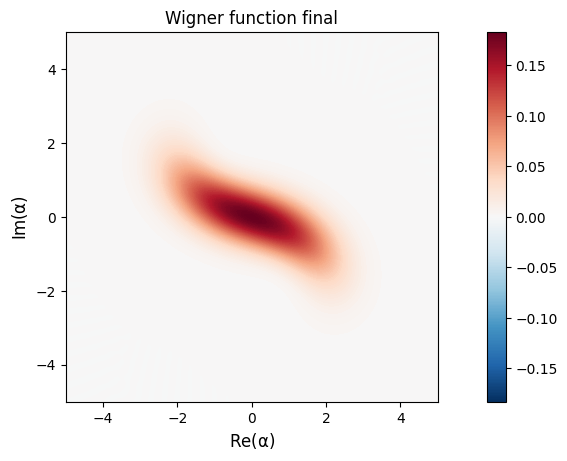

Time     | <X>        | <P>        | <n>        | <Parity>  
-----------------------------------------------------------------
0.0000   | 0.000000   | 0.000000   | 0.000000   | 1.000000
0.2020   | 0.000000   | 0.000000   | 0.006443   | 0.999190
0.4040   | 0.000000   | 0.000000   | 0.022756   | 0.994684
0.6061   | 0.000000   | 0.000000   | 0.045499   | 0.985295
0.8081   | 0.000000   | 0.000000   | 0.072309   | 0.971441
1.0101   | 0.000000   | 0.000000   | 0.101565   | 0.954250
1.2121   | 0.000000   | 0.000000   | 0.132153   | 0.934993
1.4141   | 0.000000   | 0.000000   | 0.163306   | 0.914778
1.6162   | 0.000000   | 0.000000   | 0.194497   | 0.894452
1.8182   | 0.000000   | 0.000000   | 0.225359   | 0.874593
2.0202   | 0.000000   | 0.000000   | 0.255638   | 0.855562
2.2222   | 0.000000   | 0.000000   | 0.285155   | 0.837554
2.4242   | 0.000000   | 0.000000   | 0.313786   | 0.820657
2.6263   | 0.000000   | 0.000000   | 0.341445   | 0.804882
2.8283   | 0.000000   | 0.000000   | 0.368074  

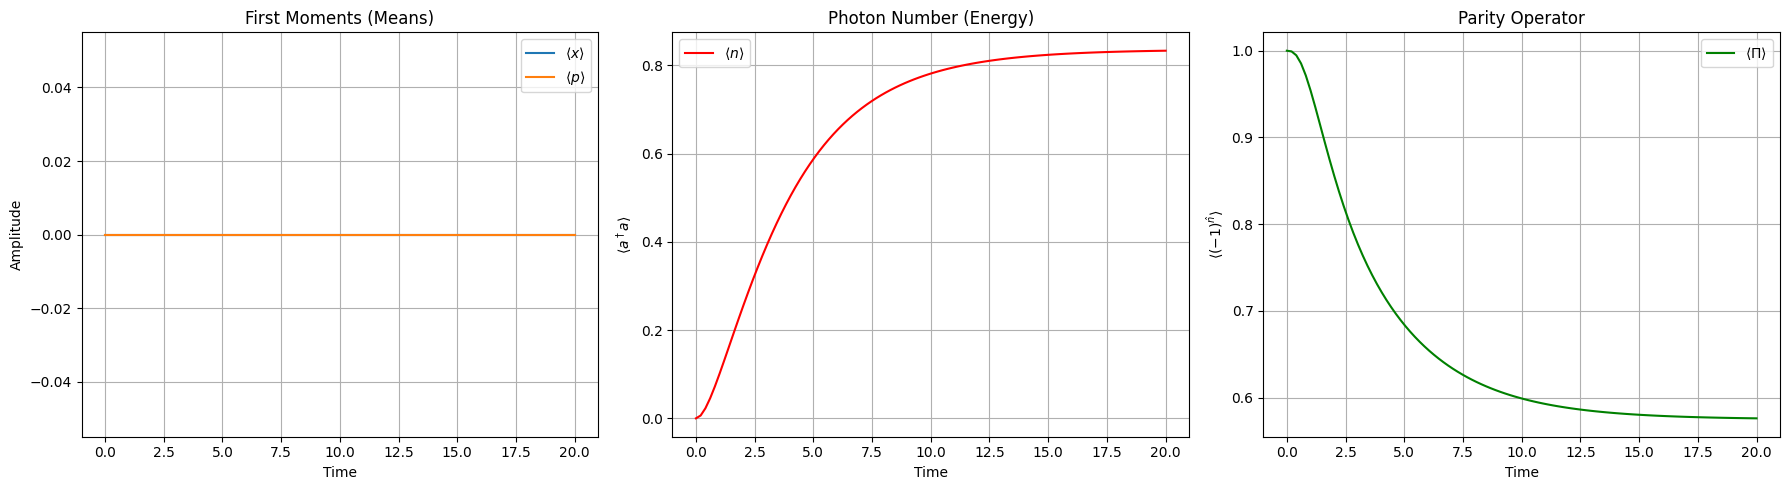

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# --- 1. Parameters ---
# Identical to your JAX setup
G = .3 + .3j    # Two-photon drive strength
delta = .1       # Detuning
U = .1         # Kerr nonlinearity
gamma = 1      # Single-photon loss rate

# Simulation parameters
N = 100            # Hilbert space cutoff (must be high enough to capture squeezing)
t_start = 0.0
t_end = 20
steps = 100       # Higher resolution than the Euler step
tlist = np.linspace(t_start, t_end, steps)

# --- 2. Operators ---
a = qt.destroy(N)
n_op = a.dag() * a
x_op = (a + a.dag()) / np.sqrt(2) # Position quadrature
p_op = 1j * (a.dag() - a) / np.sqrt(2) # Momentum quadrature

# Parity operator defined as exp(i * pi * n)
# Equivalently, it is a diagonal matrix with entries (-1)^n
parity_op = (1j * np.pi * n_op).expm() 

# --- 3. Hamiltonian Construction ---
# H_detuning = delta * a^dag * a
H_det = -delta * n_op

# H_kerr = (U/2) * a^dag^2 * a^2 (Standard Kerr form)
H_kerr = 0.5 * U * a.dag()**2 * a**2

# H_drive = G * a^dag^2 + G* * a^2 (Two-photon drive)
# Note: In some conventions, this might be i(G a^dag^2 - G* a^2).
# Based on your JAX summation, it implies a direct Hermitian addition:
H_drive = (G/2 * a.dag()**2) + (np.conj(G)/2 * a**2)

# Total Hamiltonian
# To simulate the "Only G term" case, set delta=0 and U=0 here.
H = H_drive + H_det + H_kerr

# --- 4. Dissipation ---
# Single photon loss: sqrt(gamma) * a
c_ops = [np.sqrt(gamma) * a]

# --- 5. Initial State ---
# Vacuum state
psi0 = (qt.coherent(N, 2) + qt.coherent(N, -2)).unit()
psi0 = qt.basis(N, 0)

print(np.pi*qt.wigner(psi0, 0, 0))

# --- 6. Solve Master Equation ---
result = qt.mesolve(H, psi0, tlist, c_ops, e_ops=[x_op, p_op, n_op, parity_op], options={"store_final_state":True})

# --- 7. Plotting & Verification ---
means_x = result.expect[0]
means_p = result.expect[1]
means_n = result.expect[2]
means_parity = result.expect[3]

fig, ax = qt.plot_wigner(result.final_state, xvec=np.linspace(-5,5,100), yvec=np.linspace(-5,5,100), colorbar=True, cmap='RdBu_r')


# Add plot customizations (optional)
ax.set_title("Wigner function final")
plt.show()

print(f"{'Time':<8} | {'<X>':<10} | {'<P>':<10} | {'<n>':<10} | {'<Parity>':<10}")
print("-" * 65)
for i in range(0, len(tlist), 1): # Print every 10th step
    print(f"{tlist[i]:.4f}   | {means_x[i]:.6f}   | {means_p[i]:.6f}   | {means_n[i]:.6f}   | {means_parity[i]:.6f}")

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot Means
ax[0].plot(tlist, means_x, label=r'$\langle x \rangle$')
ax[0].plot(tlist, means_p, label=r'$\langle p \rangle$')
ax[0].set_title("First Moments (Means)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[0].legend()
ax[0].grid(True)

# Plot Photon Number
ax[1].plot(tlist, means_n, label=r'$\langle n \rangle$', color='r')
ax[1].set_title("Photon Number (Energy)")
ax[1].set_xlabel("Time")
ax[1].set_ylabel(r"$\langle a^\dagger a \rangle$")
ax[1].legend()
ax[1].grid(True)

# Plot Parity
ax[2].plot(tlist, means_parity, label=r'$\langle \Pi \rangle$', color='g')
ax[2].set_title("Parity Operator")
ax[2].set_xlabel("Time")
ax[2].set_ylabel(r"$\langle (-1)^{\hat{n}} \rangle$")
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [1]:
import jax.numpy as jnp
import jax.numpy.linalg as jla
import jax
import jax.scipy.linalg as jsl
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
from typing import Union, Tuple, Iterator
import fractions
import itertools
import functools
import math
import numpy as np
from diffrax import diffeqsolve, Dopri8, Tsit5, ODETerm, SaveAt, PIDController
import diffrax
import optimistix as optx

import jax
import jax.numpy as jnp
from jax.experimental import jet
import qutip as qt
from scipy.integrate import solve_ivp
import time

jax.config.update("jax_enable_x64", True)

Rational = Union[int, fractions.Fraction]

# --- [Existing Math Helper Functions Remain Unchanged] ---

@functools.lru_cache(maxsize=None)
def binomial_coeff(n: Rational, k: int) -> Rational:
    if k < 0:
        raise ValueError("k must be a non-negative integer")
    n = fractions.Fraction(n)
    result = 1
    for i in range(k):
        result *= (n - i) / (i + 1)
    return result

MultiIndex = Tuple[int, ...]

def multi_index_lte(i: MultiIndex) -> Iterator[MultiIndex]:
    return itertools.islice(
        itertools.product(*(range(0, k + 1) for k in i)),
        1,
        None,
    )

@functools.lru_cache(maxsize=None)
def multi_index_binomial_coeff(i: Tuple[Rational, ...],
                               j: MultiIndex) -> Rational:
    result = 1
    for i_k, j_k in zip(i, j):
        result *= binomial_coeff(i_k, j_k)
    return result

def coeffs(i: MultiIndex) -> Iterator[Tuple[MultiIndex, Rational]]:
    for j in multi_index_lte(i):
        c = multi_index_binomial_coeff(i, j) * (-1)**(sum(i) - sum(j))
        if c != 0:
            yield j, c

@functools.lru_cache(maxsize=None)
def precompute_kc(orders: MultiIndex) -> Tuple[np.ndarray, np.ndarray]:
    ks, cs = [], []
    for k, c in coeffs(orders):
        k = np.array(list(map(float, k)))
        c = float(c)
        ks.append(list(k))
        cs.append(c)
    ks = np.array(ks)
    cs = np.array(cs)
    return ks, cs

def mixed_partial(f, orders: MultiIndex):
    d = sum(orders)
    ks, cs = precompute_kc(orders)
    dfact = math.factorial(d)

    def partial_der(x0):
        @jax.vmap
        def jetter(j):
            hs = (j, ) + (jnp.zeros_like(x0), ) * (d - 1)
            _, (*_, res) = jet.jet(f, (x0, ), (hs, ),)
            return res
        return jnp.sum(jetter(ks) * cs) / dfact
    return partial_der

# --- [Physical Constants and Model Definition] ---

G = 30 + 30j
delta = 0
U = 10
gamma = 0
eta = 10

def calculate_covariance(covariance_params):
    r,phi = covariance_params
    S = jnp.array([
        [jnp.cos(phi), jnp.sin(phi)],
        [jnp.sin(phi), -jnp.cos(phi)]
    ])
    Sigma = 0.5*jnp.cosh(2*r)*jnp.identity(2)-0.5*jnp.sinh(2*r)*S
    return Sigma

def covariance_sum_inv(covariance_params_a, covariance_params_b):
    ra, phia = covariance_params_a
    rb, phib = covariance_params_b
    
    denom = (1. + jnp.cosh(ra)**2 * jnp.cosh(2 * rb) + 
             jnp.cosh(2 * rb) * jnp.sinh(ra)**2 - 
             4. * jnp.cos(phia - phib) * jnp.cosh(ra) * jnp.cosh(rb) * jnp.sinh(ra) * jnp.sinh(rb))
             
    num00 = (jnp.cosh(2 * ra) + jnp.cosh(2 * rb) + 
             2. * jnp.cos(phia) * jnp.cosh(ra) * jnp.sinh(ra) + 
             2. * jnp.cos(phib) * jnp.cosh(rb) * jnp.sinh(rb))
             
    num01 = (2. * jnp.cosh(ra) * jnp.sin(phia) * jnp.sinh(ra) + 
             2. * jnp.cosh(rb) * jnp.sin(phib) * jnp.sinh(rb))
             
    num11 = (jnp.cosh(2 * ra) + jnp.cosh(2 * rb) - 
             2. * jnp.cos(phia) * jnp.cosh(ra) * jnp.sinh(ra) - 
             2. * jnp.cos(phib) * jnp.cosh(rb) * jnp.sinh(rb))
             
    return jnp.array([[num00, num01], [num01, num11]]) / denom

def unwrap_params(params):
    normalization = params[0]
    mean = params[1:5]
    covariance_params = params[5:7]
    return normalization, mean, covariance_params

def generating_function(params_a, params_b, Js):
    normalization_a, mean_a, covariance_params_a = unwrap_params(params_a)
    normalization_b, mean_b, covariance_params_b = unwrap_params(params_b)
    alpha_a, beta_a = mean_a[::2], mean_a[1::2]
    alpha_b, beta_b =  mean_b[::2], mean_b[1::2]
    J, J_tilde = Js[:Js.size//2], Js[Js.size//2:]
    
    M_modes = 1
    covariance_a = calculate_covariance(covariance_params_a)
    covariance_b = calculate_covariance(covariance_params_b)
    
    covariance_sum = covariance_a + covariance_b
    inv_sigma_sum = covariance_sum_inv(covariance_params_a, covariance_params_b)
    
    v1 = alpha_b - alpha_a - jnp.dot(covariance_a, J) - J_tilde
    inv_sigma_sum_v1 = jnp.dot(inv_sigma_sum, v1)
    
    diff_beta = beta_b - beta_a
    sum_beta = beta_b + beta_a
    inv_sigma_sum_diff_beta = jnp.dot(inv_sigma_sum, diff_beta)
    inv_sigma_sum_sum_beta = jnp.dot(inv_sigma_sum, sum_beta)

    Z1 = jnp.exp(-0.5 * jnp.dot(v1, inv_sigma_sum_v1))
    M_minus = jnp.exp(0.5 * jnp.dot(diff_beta, inv_sigma_sum_diff_beta))
    M_plus = jnp.exp(0.5 * jnp.dot(sum_beta, inv_sigma_sum_sum_beta))
    
    J_dot_beta = jnp.dot(J, beta_a)
    mix_term_minus = jnp.dot(diff_beta, inv_sigma_sum_v1)
    mix_term_plus = jnp.dot(sum_beta, inv_sigma_sum_v1)
    
    C_minus = jnp.cos(J_dot_beta - mix_term_minus)
    C_plus = jnp.cos(J_dot_beta + mix_term_plus)
    num_exponent = 0.5 * jnp.dot(J, jnp.dot(covariance_a, J)) + jnp.dot(J, alpha_a)
    
    sign, logdet = jnp.linalg.slogdet(covariance_sum)
    log_denominator = 0.5 * (2*M_modes * jnp.log(2 * jnp.pi) + logdet)
    prefactor = 0.5 * jnp.exp(num_exponent - log_denominator)
    
    return normalization_a*normalization_b*prefactor * Z1 * (M_minus * C_minus + M_plus * C_plus)

@jax.jit
def geometric_tensor(params):
    def total_gen_func(params_a, params_b):
        params_a = duplicate_with_neg_mean(params_a)
        params_b = duplicate_with_neg_mean(params_b)
        #params_a = renormalize_params(params_a)
        #params_b = renormalize_params(params_b)
        return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: generating_function(param_a, param_b, jnp.zeros((4))))(params_a))(params_b))
    return jax.jacfwd(jax.grad(total_gen_func, argnums=(1)), argnums=(0))(params, params).reshape(params.size, params.size)

@jax.jit
def geometric_tensor_nondup(params):
    def total_gen_func(params_a, params_b):
        #params_a = renormalize_params(params_a)
        #params_b = renormalize_params(params_b)
        return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: generating_function(param_a, param_b, jnp.zeros((4))))(params_a))(params_b))
    return jax.jacfwd(jax.grad(total_gen_func, argnums=(1)), argnums=(0))(params, params).reshape(params.size, params.size)


def g(param_a, param_b, orders):
    if sum(orders) == 0:
        return generating_function(param_a, param_b, jnp.zeros((4)))
    g_f = partial(generating_function, param_a, param_b)
    return mixed_partial(g_f, orders)(jnp.zeros((4)))

def g_term(param_a, param_b):
    real_term = jnp.real(G)*(g(param_a, param_b,(0,1,1,0))+g(param_a, param_b,(1,0,0,1)))
    imag_term = jnp.imag(G)*(g(param_a, param_b,(1,0,1,0))-g(param_a, param_b,(0,1,0,1)))
    return real_term - imag_term

def delta_term(param_a, param_b):
    return delta*(g(param_a, param_b,(0,1,1,0))-g(param_a, param_b,(1,0,0,1)))

def u_term(param_a, param_b):
    total = g(param_a, param_b, (3,0,0,1)) 
    total += g(param_a, param_b, (1,2,0,1)) 
    total += -g(param_a, param_b, (2,1,1,0))
    total += -g(param_a, param_b, (0,3,1,0))
    total += 2*g(param_a, param_b, (0,1,1,0))
    total += -2*g(param_a, param_b, (1,0,0,1))
    total += 0.25*g(param_a, param_b, (0,1,3,0))
    total += -0.25*g(param_a, param_b, (1,0,0,3))
    total += -0.25*g(param_a, param_b, (1,0,2,1))
    total += 0.25*g(param_a, param_b, (0,1,1,2))
    return U/2*total

def single_photon_loss_term(param_a, param_b):
    total = g(param_a, param_b, (1, 0, 1, 0))
    total += g(param_a, param_b, (0, 1, 0, 1))
    total += 2*g(param_a, param_b, (0, 0, 0, 0))
    total += 0.5*g(param_a, param_b, (0,0,2,0))
    total += 0.5*g(param_a, param_b, (0,0,0,2))
    return gamma/2*total

def double_photon_loss_term(param_a, param_b):
    total = 1/2*g(param_a, param_b, (3, 0, 1, 0))
    total += 1/2*g(param_a, param_b, ( 1, 2, 1, 0))
    total += 1/2*g(param_a, param_b, (0, 3, 0, 1))
    total += 1/2*g(param_a, param_b, (2, 1, 0, 1))
    total += 2*g(param_a, param_b, (2, 0, 0, 0))
    total += 2*g(param_a, param_b, (0, 2, 0, 0))
    total += g(param_a, param_b, (1, 0, 1, 0))
    total += g(param_a, param_b, (0, 1, 0, 1))
    total += 1/2*g(param_a, param_b, (2, 0, 2, 0))
    total += 1/2*g(param_a, param_b, (2, 0, 0, 2))
    total += 1/2*g(param_a, param_b, (0, 2, 2, 0))
    total += 1/2*g(param_a, param_b, (0, 2, 0, 2))
    total += 1/8*g(param_a, param_b, (1, 0, 3, 0))
    total += 1/8*g(param_a, param_b, (0, 1, 0, 3))
    total += 1/8*g(param_a, param_b, (1, 0, 1, 2))
    total += 1/8*g(param_a, param_b, (0, 1, 2, 1))
    return eta*total

def all_terms(params_a, params_b):
    params_a = duplicate_with_neg_mean(params_a)
    params_b = duplicate_with_neg_mean(params_b)
    #params_a = renormalize_params(params_a)
    #params_b = renormalize_params(params_b)
    def func(param_a, param_b):
        return g_term(param_a, param_b) + delta_term(param_a, param_b) + u_term(param_a, param_b) + single_photon_loss_term(param_a, param_b) + double_photon_loss_term(param_a, param_b)
    return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: func(param_a, param_b))(params_b))(params_a))

@jax.jit
def liouvillian_gradient(params):
    return jax.grad(all_terms, argnums=0) (params, params)

def renormalize_params(params):
    total_weight = jnp.sum(params[:, 0])
    return params.at[:, 0].set(params[:, 0]/ total_weight)

@jax.jit
def number_operator(params):
    params = duplicate_with_neg_mean(params)
    params = renormalize_params(params)
    # Vectorized helper for number operator within vmap
    def single_param_n(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2]
        return normalization*(jnp.sum(jnp.real(mean**2))+covariance[0,0]+covariance[1,1]-1)/2
    
    return jnp.sum(jax.vmap(single_param_n)(params))

@jax.jit
def parity_operator(params):
    # Vectorized helper for parity operator within vmap
    params = duplicate_with_neg_mean(params)
    params = renormalize_params(params)
    def single_param_parity(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2] # Used in original, but math below uses real vector mean
        term = jnp.exp(-0.5 * jnp.dot(-mean, jnp.dot(jla.inv(covariance), -mean)))
        return jnp.pi * normalization * jnp.real(term) / jnp.sqrt((2*jnp.pi)**2 * jnp.linalg.det(covariance))

    return jnp.sum(jax.vmap(single_param_parity)(params))

def plot_wigner(params, filename, exact_state=None):
    x = jnp.linspace(-5, 5, 100)
    p = jnp.linspace(-5, 5, 100)
    X, P = jnp.meshgrid(x, p)
    W = jnp.zeros(X.shape)
    
    # We can keep the loop here as visualization is not the bottleneck
    # or vectorize it if needed, but loop is fine for plotting at start/end
    params = duplicate_with_neg_mean(params)
    params = renormalize_params(params)
    for param in params:
        normalization, mean, covariance_params = unwrap_params(param)
        covariance = calculate_covariance(covariance_params)
        det_cov = jla.det(covariance)
        inv_cov = jla.inv(covariance)
        phase_vars = jnp.array([X.flatten(), P.flatten()]).T
        mean = mean[::2]+ 1j* mean[1::2]
        diff = phase_vars - mean
        exponent = -0.5 * jnp.einsum("ij,ij->i", jnp.dot(diff, inv_cov), diff)
        exponent = exponent.reshape(X.shape)
        W += normalization/(2*jnp.pi*jnp.sqrt(det_cov)) * jnp.real(jnp.exp(exponent))
        
    norm = matplotlib.colors.Normalize(-abs(W).max(), abs(W).max())
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    cf = ax[0].contourf(X, P, W, levels=200, cmap='RdBu_r', norm=norm)
    fig.colorbar(cf, ax=ax[0])
    if exact_state is not None:
        qt.plot_wigner(exact_state, xvec=x, yvec=p, ax=ax[1], cmap='RdBu_r', colorbar=True)
        w_exact = qt.wigner(exact_state, xvec=x, yvec=p)
        cf_diff = ax[2].contourf(X, P, jnp.abs(w_exact - W), levels=200, cmap='RdBu_r')
        fig.colorbar(cf_diff, ax=ax[2])
    
    plt.title('Wigner Function')
    #plt.savefig(filename)

# --- [Initialization Functions] ---

def initialize_cat_state(alpha=1.0):
    N_G = 4
    params = jnp.zeros((N_G, 7))
    weights = jnp.ones(N_G) 
    params = params.at[:, 0].set(weights)
    params = params.at[2:, 0].set(jnp.exp(-2 * (alpha)**2))
    
    dist = jnp.sqrt(2) * alpha
    params = params.at[0, 1].set(dist)
    params = params.at[1, 1].set(-dist)
    params = params.at[2, 4].set(dist)
    params = params.at[3, 4].set(-dist)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    return params

def initialize_vacuum_state(N_G):
    params = jnp.zeros((N_G, 7))
    params = params.at[:, 0].set(1.0)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    return params

def expand_state_cluster(params, expansion_factor=4, noise_scale=1e-4, key=None):
    if key is None:
        key = jax.random.PRNGKey(0)
    old_N = params.shape[0]
    new_N = old_N * expansion_factor
    new_params = jnp.zeros((new_N, 7))
    print(f"Expanding ansatz from {old_N} to {new_N} Gaussians...")
    for i in range(old_N):
        base_weight = params[i, 0]
        base_center = params[i, 1:5] # Fixed slicing index from original code
        base_cov = params[i, 5:7]
        key, subkey = jax.random.split(key)
        offsets = jax.random.normal(subkey, (expansion_factor, 4)) * noise_scale # Offset for 4 center coords
        start_idx = i * expansion_factor
        end_idx = start_idx + expansion_factor
        new_weights = (base_weight / expansion_factor) * jnp.ones(expansion_factor)
        weight_jitter = 1.0 
        random_weight = jax.random.uniform(subkey, (expansion_factor,)) 
        new_params = new_params.at[start_idx:end_idx, 0].set(random_weight)
        new_centers = base_center + offsets
        new_params = new_params.at[start_idx:end_idx, 1:5].set(new_centers)
        new_params = new_params.at[start_idx:end_idx, 5:7].set(base_cov)
        random_r = jax.random.normal(subkey, (expansion_factor,)) * 1e-5
        #new_params = new_params.at[start_idx:end_idx, 5].set(random_r)
        random_rots = jax.random.uniform(subkey, (expansion_factor,)) * 2 * jnp.pi
        #new_params = new_params.at[start_idx:end_idx, 6].set(random_rots)
    total_weight = jnp.sum(new_params[:, 0])
    new_params = new_params.at[:, 0].divide(total_weight)
    return new_params

def duplicate_with_neg_mean(params):
    neg_params = params.at[:, 1:5].set(-params[:, 1:5])
    params = jnp.concatenate([params, neg_params], axis=0)
    params = params.at[:, 0].divide(2)
    return params


def diagnose_t_blocks(T, num_gaussians=8):
    # Parameters per Gaussian: 7 (norm, 4 means, r, phi)
    block_size = 7
    
    # Reshape T into [N_G, block_size, N_G, block_size]
    # and transpose to [N_G, N_G, block_size, block_size]
    # to access blocks T[m, n]
    blocks = T.reshape(num_gaussians, block_size, num_gaussians, block_size).transpose(0, 2, 1, 3)
    
    # 1. Analyze Diagonal Blocks (Local Stability)
    def get_diag_cond(i):
        diag_block = blocks[i, i]
        # Use singular values for a robust condition number calculation
        return jnp.linalg.cond(diag_block)

    diag_conds = jax.vmap(get_diag_cond)(jnp.arange(num_gaussians))
    
    # 2. Analyze Off-Diagonal Blocks (Redundancy/Overlap)
    # We look for blocks where T[i,j] is nearly identical to T[i,i]
    def get_max_overlap(i):
        def compare_to_j(j):
            # If i == j, ignore (overlap is 1.0)
            return jax.lax.cond(
                i == j,
                lambda: 0.0,
                lambda: jnp.linalg.norm(blocks[i, j]) / jnp.linalg.norm(blocks[i, i])
            )
        return jnp.max(jax.vmap(compare_to_j)(jnp.arange(num_gaussians)))

    overlaps = jax.vmap(get_max_overlap)(jnp.arange(num_gaussians))
    
    return diag_conds, overlaps

@jax.jit
def compute_update_step(t, params_flat, args):
    params = params_flat.reshape((-1,7))
    params = renormalize_params(params)
    # Calculate Gradient and Geometric Tensor
    V = liouvillian_gradient(params).flatten()
    T = geometric_tensor(params)
    # Logging for diagnostics
    def log_fn(args):
        t_val = args
        jax.debug.print(
            "t: {t_v} | N: {m} | P: {p}",
            t_v=t_val, m=number_operator(params), p=parity_operator(params)
        )
        diag_conds, overlaps = diagnose_t_blocks(T, num_gaussians=params.shape[0])
        jax.debug.print("Diag Conds: {dc}", dc=diag_conds)
        jax.debug.print("Max Overlaps: {mo}", mo=overlaps)

    d_params = jla.solve(T + 1e-12*jnp.eye(T.shape[0]), V)
    #d_params = jla.lstsq(T, V, rcond=1e-12)[0]
    log_condition = jnp.mod(t, 0.001) < 1e-6
    jax.lax.cond(
        log_condition,
        log_fn,
        lambda _: None,
        t,
    )

    return d_params.flatten()

def time_evolve(initial_time, end_time, params=None, N_G=6):
    # Simulation parameters
    N = 100            # Hilbert space cutoff (must be high enough to capture squeezing)
    steps = 100       # Higher resolution than the Euler step
    t_eval = jnp.linspace(initial_time, end_time, 50)

    # --- 2. Operators ---
    a = qt.destroy(N)
    n_op = a.dag() * a
    x_op = (a + a.dag()) / np.sqrt(2) # Position quadrature
    p_op = 1j * (a.dag() - a) / np.sqrt(2) # Momentum quadrature

    # Parity operator defined as exp(i * pi * n)
    # Equivalently, it is a diagonal matrix with entries (-1)^n
    parity_op = (1j * np.pi * n_op).expm() 

    # --- 3. Hamiltonian Construction ---
    # H_detuning = delta * a^dag * a
    H_det = -delta * n_op

    # H_kerr = (U/2) * a^dag^2 * a^2 (Standard Kerr form)
    H_kerr = 0.5 * U * a.dag()**2 * a**2

    # H_drive = G * a^dag^2 + G* * a^2 (Two-photon drive)
    # Note: In some conventions, this might be i(G a^dag^2 - G* a^2).
    # Based on your JAX summation, it implies a direct Hermitian addition:
    H_drive = (G/2 * a.dag()**2) + (np.conj(G)/2 * a**2)

    # Total Hamiltonian
    # To simulate the "Only G term" case, set delta=0 and U=0 here.
    H = H_drive + H_det + H_kerr

    # --- 4. Dissipation ---
    # Single photon loss: sqrt(gamma) * a
    c_ops = [np.sqrt(gamma) * a, np.sqrt(eta) * a**2]

    # --- 5. Initial State ---
    # Vacuum state
    psi0 = (qt.coherent(N, 2) + qt.coherent(N, -2)).unit()
    psi0 = qt.basis(N, 0)

    # --- 6. Solve Master Equation ---
    result = qt.mesolve(H, psi0, np.linspace(0,end_time,100), c_ops, e_ops=[x_op, p_op, n_op, parity_op], options={"store_final_state":True})

    # --- 7. Plotting & Verification ---
    means_x = result.expect[0]
    means_p = result.expect[1]
    means_n = result.expect[2]
    means_parity = result.expect[3]
    #params = initialize_cat_state(alpha=2)
    if params is None:
        params = initialize_vacuum_state(N_G=1)
        params = expand_state_cluster(params, expansion_factor=N_G, noise_scale=1e-2)
    param_shape = params.shape
    
    # Initial Plot
    print("Plotting initial state...")
    plot_wigner(params, "initial_state.png", exact_state=psi0)

    
    print(f"Starting integration from t={initial_time} to {end_time}...")
    term = ODETerm(compute_update_step)
    solver = diffrax.Dopri8()
    saveat = SaveAt(ts=t_eval)
    def test_norm(val):
        norm = optx.rms_norm(val)
        def log_fn(args):
            jax.debug.print("Step norm: {val} {norm}", val=val.reshape((-1,7)), norm=norm)
        log_condition = norm > 1
        jax.lax.cond(
            log_condition,
            log_fn,
            lambda _: None,
            None
        )
        return norm

    stepsize_controller = PIDController(rtol=1e-3, atol=1e-6)

    progress_meter = diffrax.TextProgressMeter()
    sol = diffeqsolve(term, solver, t0=initial_time, t1=end_time, dt0=None, y0=params.flatten(), saveat=saveat,
                    stepsize_controller=stepsize_controller, max_steps=None, progress_meter=progress_meter)
        
    print("Integration complete. Computing observables...")
    print(sol.stats)

    # 5. Post-process Observables using JAX Vmap (Much faster than looping)
    # sol.y shape is (num_params, num_timesteps). Transpose to (num_timesteps, num_params)
    time_evolution_flat = sol.ys
    # Reshape to (num_timesteps, N_G, 8)
    time_evolution_params = time_evolution_flat.reshape(-1, *param_shape)
    
    # Vectorize observable functions over the time axis
    compute_all_n = jax.vmap(number_operator)
    compute_all_parity = jax.vmap(parity_operator)
    
    ns = compute_all_n(time_evolution_params)
    parities = compute_all_parity(time_evolution_params)

    print("Initial:", ns[0], parities[0])
    
    # 6. Final Plot and Analysis
    final_params = time_evolution_params[-1]
    #final_params = renormalize_params(final_params)

    plot_wigner(final_params, "final_state.png", exact_state=result.final_state)
    print(result)
    print("Final Time:", t_eval[-1])
    print("Final Params:\n", final_params)
    print("Final Number Operator:", ns[-1])
    print("Final Parity Operator:", parities[-1])
    return sol


W0118 21:38:23.831844   35874 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0118 21:38:23.834089   35783 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [53]:
params = initialize_vacuum_state(N_G=1)
params = expand_state_cluster(params, expansion_factor=2, noise_scale=1e-4)
params = renormalize_params(params)
print(params)
T = geometric_tensor(params)
u, s, vh = jnp.linalg.svd(T)
print(s)
print(jnp.argmin(s[jnp.nonzero(s)]))
print(s[jnp.nonzero(s)].min())
print(vh[jnp.nonzero(s)][jnp.argmin(s[jnp.nonzero(s)])].reshape((-1,7)))


Expanding ansatz from 1 to 2 Gaussians...
[[ 8.02573336e-02 -1.40088410e-04  1.43214500e-04  6.24810696e-05
   2.00487272e-05  0.00000000e+00  0.00000000e+00]
 [ 9.19742666e-01  2.47147611e-05  5.24477101e-05  8.61868644e-05
   1.22371455e-04  0.00000000e+00  0.00000000e+00]]
[1.35658560e-01 1.35658560e-01 1.35658555e-01 6.40239089e-09
 9.05885347e-10 5.64092874e-11 6.90982179e-17 1.69625745e-18
 9.71970820e-19 6.36075185e-19 4.83546198e-19 1.90302313e-19
 0.00000000e+00 0.00000000e+00]
11
1.9030231316098463e-19
[[-1.17097386e-03 -1.90600240e-02 -5.55032982e-01  7.91551464e-01
   1.65209112e-01  1.43405668e-04  0.00000000e+00]
 [ 1.04665580e-04  1.66299459e-03 -1.47178007e-01 -6.90713136e-02
   1.06258897e-01  1.73452951e-05  0.00000000e+00]]


Expanding ansatz from 1 to 16 Gaussians...
Plotting initial state...
Starting integration from t=0.0 to 0.15...
0.00%
t: 0.0 | N: -3.854984868142705e-06 | P: 1.000007698256159
Max Overlaps: [1.00034169 1.00026634 1.00038856 1.00034708 1.00042789 1.00045181
 0.99980678 1.00027888 1.00042252 1.00041183 1.0003341  1.00030556
 1.00043084 1.00047922 1.00018866 1.00037145]
Diag Conds: [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf]
t: 0.01 | N: nan | P: nan
Max Overlaps: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Diag Conds: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
t: 0.01 | N: nan | P: nan
Max Overlaps: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Diag Conds: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
t: 0.01 | N: nan | P: nan
Max Overlaps: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Diag Conds: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


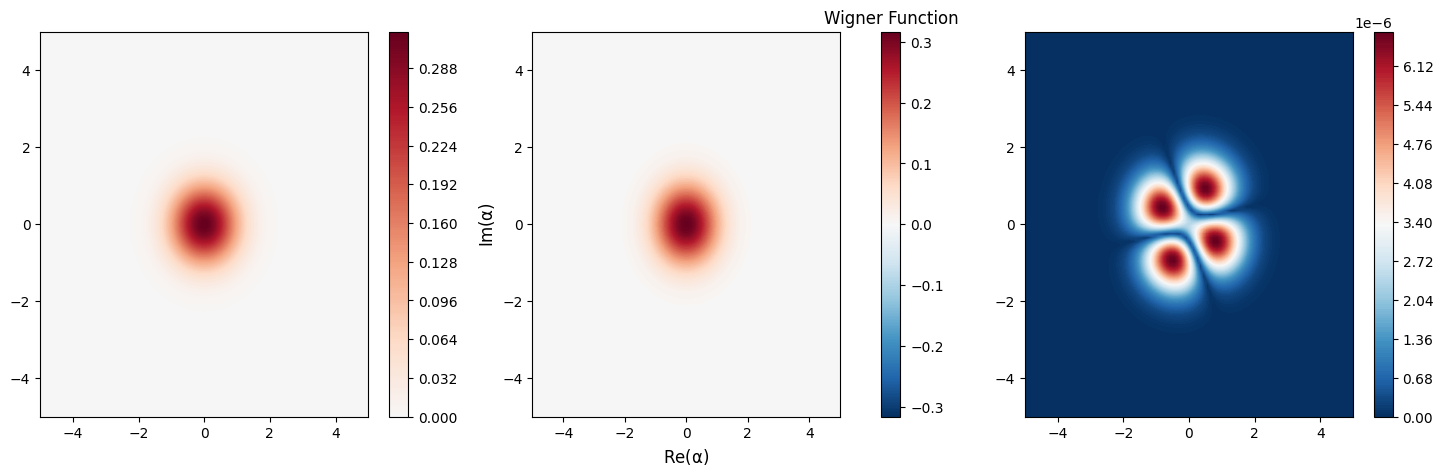

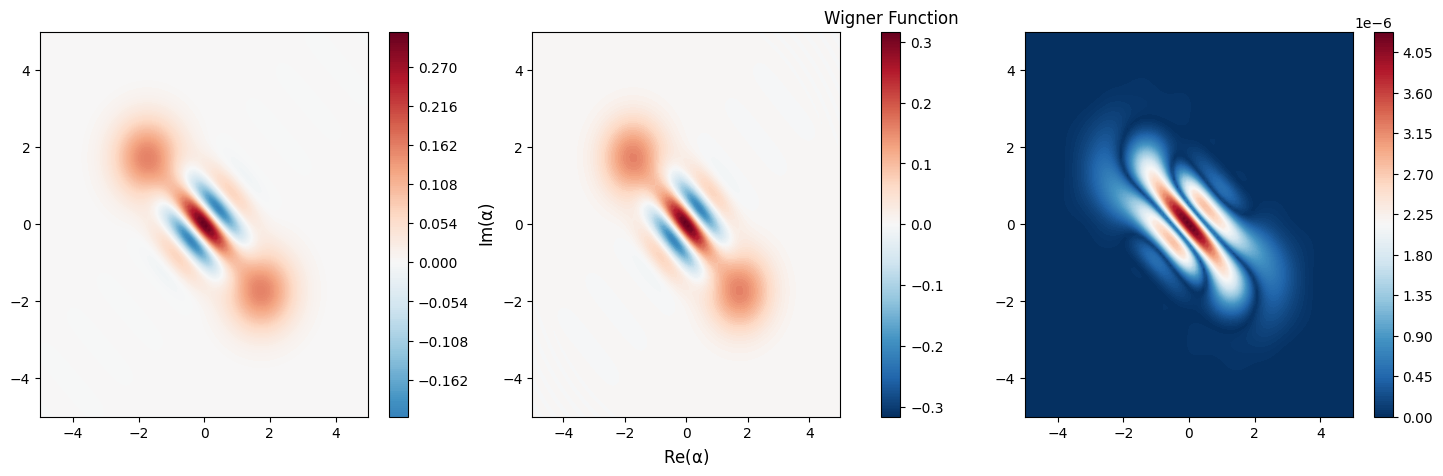

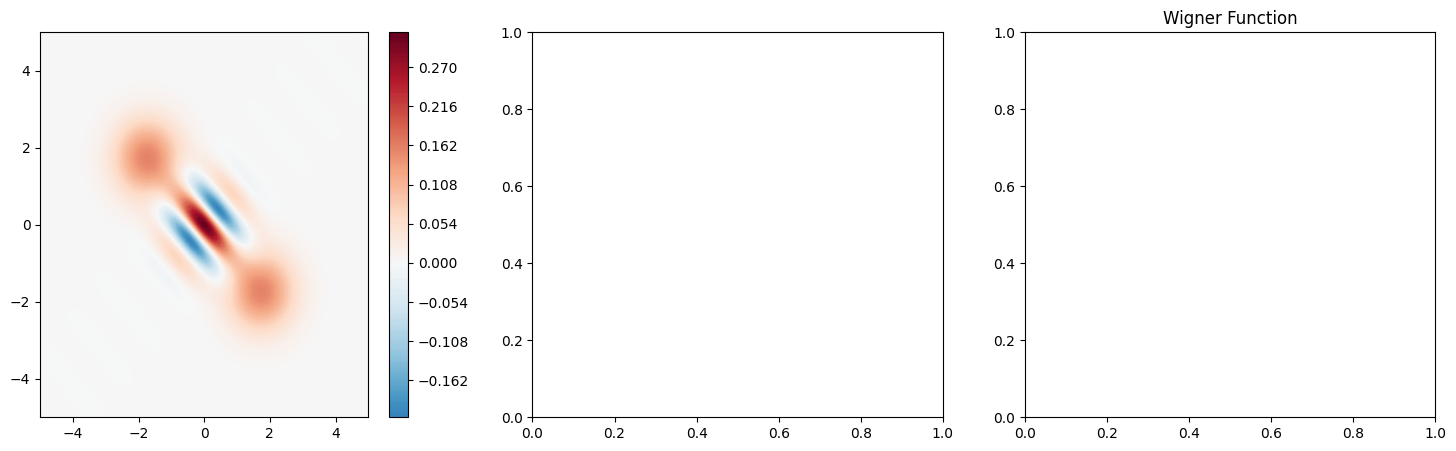

In [2]:
N_G = 16
sol = time_evolve(0.0, 0.15, N_G=N_G)

final_params = sol.ys.reshape(-1, *(N_G,7))[-1]
print(final_params)
T = geometric_tensor(final_params)
# Usage in your compute_update_step:
diag_conds, overlaps = diagnose_t_blocks(T, num_gaussians=N_G)

print(diag_conds)
print(overlaps)
print(f"Worst Diag Cond: {jnp.max(diag_conds)} (Gaussian {jnp.argmax(diag_conds)})")
print()

final_params_alt = final_params
print(final_params_alt)

plot_wigner(final_params_alt, "final_state_single_gaussian.png", exact_state=None)


Expanding ansatz from 1 to 3 Gaussians...
Plotting initial state...
Starting integration from t=0.0 to 0.01994...
0.00%
Max Overlaps: [[0.         1.00009045 0.99984824]
 [0.9999085  0.         0.99975724]
 [1.00015127 1.00024223 0.        ]]
t: 0.0 | N: 7.335114715993164e-06 | P: 0.9999852757994026
Diag Conds: [1.76903552e+13 1.76935795e+13 1.76849938e+13]
Max Overlaps: [[ 0. nan nan]
 [nan  0. nan]
 [nan nan  0.]]
t: 0.01 | N: nan | P: nan
Diag Conds: [nan nan nan]
Max Overlaps: [[ 0. nan nan]
 [nan  0. nan]
 [nan nan  0.]]
t: 0.01 | N: nan | P: nan
Diag Conds: [nan nan nan]
Max Overlaps: [[ 0. nan nan]
 [nan  0. nan]
 [nan nan  0.]]
t: 0.01 | N: nan | P: nan
Diag Conds: [nan nan nan]
Max Overlaps: [[0.         1.00009045 0.99984824]
 [0.9999085  0.         0.99975724]
 [1.00015127 1.00024223 0.        ]]
t: 0.0 | N: 7.335114715993164e-06 | P: 0.9999852757994026
Diag Conds: [1.76903552e+13 1.76935795e+13 1.76849938e+13]
Max Overlaps: [[ 0. nan nan]
 [nan  0. nan]
 [nan nan  0.]]
t: 0

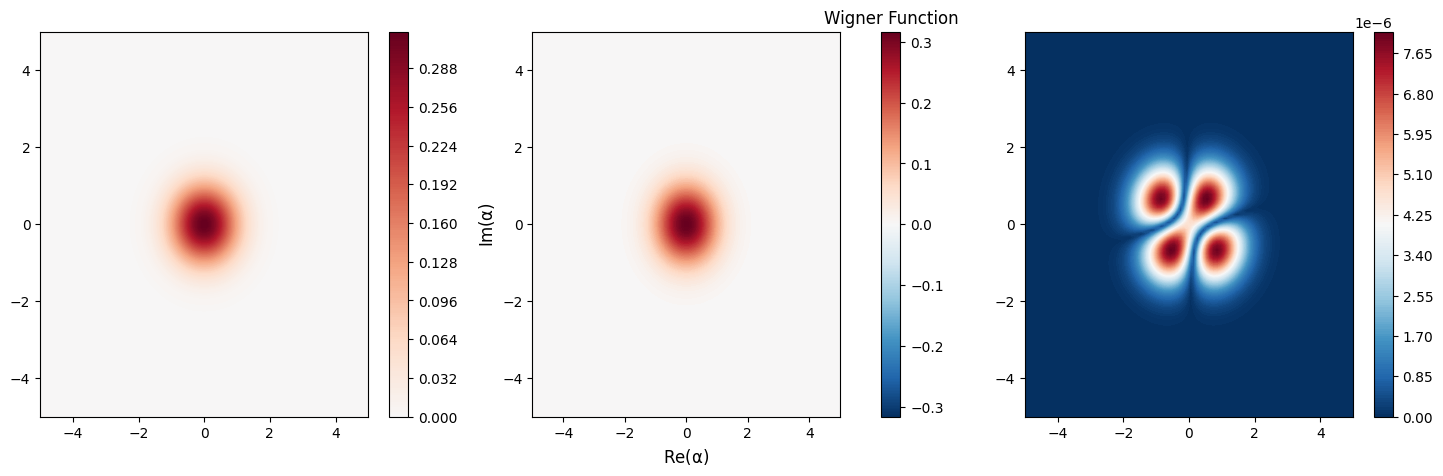

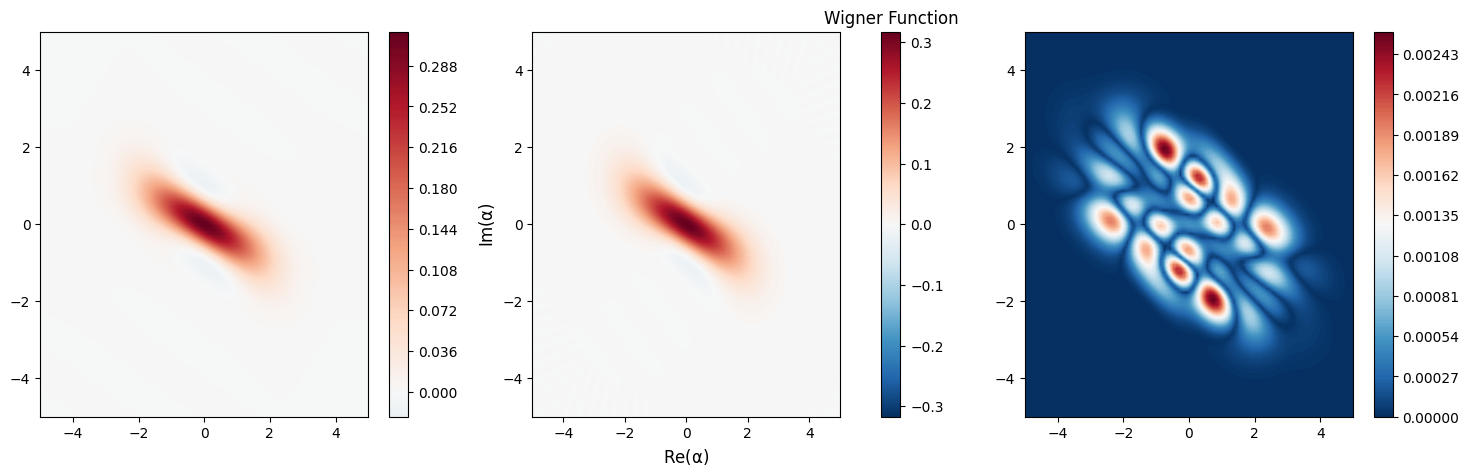

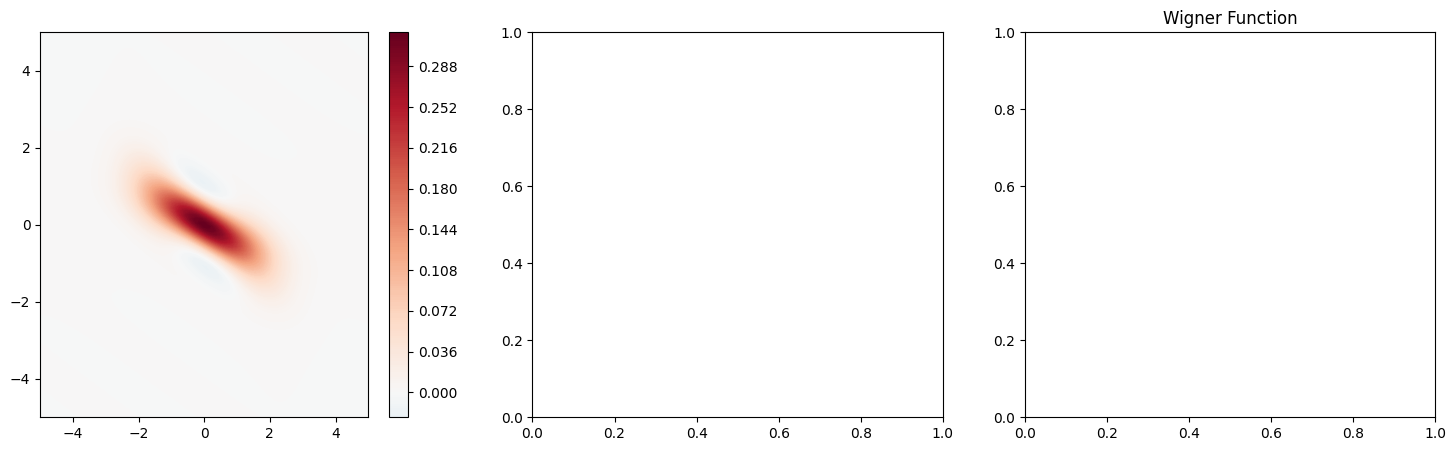

In [34]:
N_G = 3
sol = time_evolve(0.0, 0.01994, N_G=N_G)

final_params = sol.ys.reshape(-1, *(N_G,7))[-1]
print(final_params)
T = geometric_tensor(final_params)
# Usage in your compute_update_step:
diag_conds, overlaps = diagnose_t_blocks(T, num_gaussians=N_G)

print(diag_conds)
print(overlaps)
print(f"Worst Diag Cond: {jnp.max(diag_conds)} (Gaussian {jnp.argmax(diag_conds)})")
print()

final_params_alt = final_params
print(final_params_alt)

plot_wigner(final_params_alt, "final_state_single_gaussian.png", exact_state=None)

T_alt = geometric_tensor_nondup(final_params_alt.reshape(-1,7))
T_alt_blocks = T_alt.reshape(N_G, 7, N_G, 7).transpose(0, 2, 1, 3)
u, s, vh = jnp.linalg.svd(T_alt_blocks[2,2])

# The last row of vh (right singular vector) corresponds to the 
# parameter direction causing the most ill-conditioning
trouble_direction = vh[-1]
print(s)
print("Most troublesome direction in parameter space for Gaussian 2:", trouble_direction)
# Usage in your compute_update_step:
diag_conds, overlaps = diagnose_t_blocks(T_alt, num_gaussians=N_G)

u, s, vh = jnp.linalg.svd(T_alt)
print(vh[-1])


print(diag_conds)
print(overlaps)
print(f"Worst Diag Cond: {jnp.max(diag_conds)} (Gaussian {jnp.argmax(diag_conds)})")

Expanding ansatz from 1 to 6 Gaussians...
Plotting initial state...
Starting integration from t=0 to 0.036...
0.00%
t: 0.0 | N: 4.101843792321999e-05 | P: 0.9999179034947786
t: 0.01 | N: nan | P: nan
t: 0.01 | N: nan | P: nan
t: 0.01 | N: nan | P: nan
t: 0.0 | N: 4.101843792321999e-05 | P: 0.9999179034947786
t: 0.002 | N: nan | P: nan
t: 0.002 | N: nan | P: nan
t: 0.002 | N: nan | P: nan
t: 0.0 | N: 4.101843792321999e-05 | P: 0.9999179034947786
t: 0.0 | N: 4.101843792321999e-05 | P: 0.9999179034947786
t: 0.0 | N: 4.101843792321999e-05 | P: 0.9999179034947786
t: 0.0 | N: 4.101843792321999e-05 | P: 0.9999179034947786
t: 7.795230247343763e-07 | N: 4.122939227487682e-05 | P: 0.9999174848991583
t: 0.0 | N: 4.101843792321999e-05 | P: 0.9999179034947786
t: 5.030478654152633e-07 | N: 4.1106260934330304e-05 | P: 0.999917729210875
t: 7.545717981228949e-07 | N: 4.103706797204649e-05 | P: 0.9999178677657535
t: 0.0 | N: 4.101843792321999e-05 | P: 0.9999179034947786
t: 3.902402547198033e-07 | N: 4.1

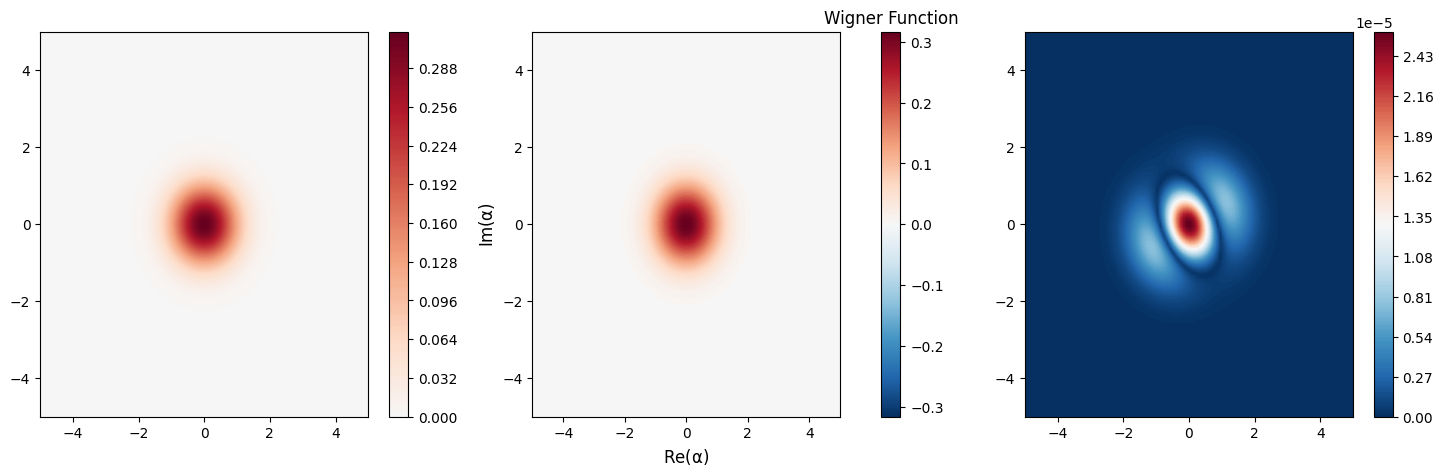

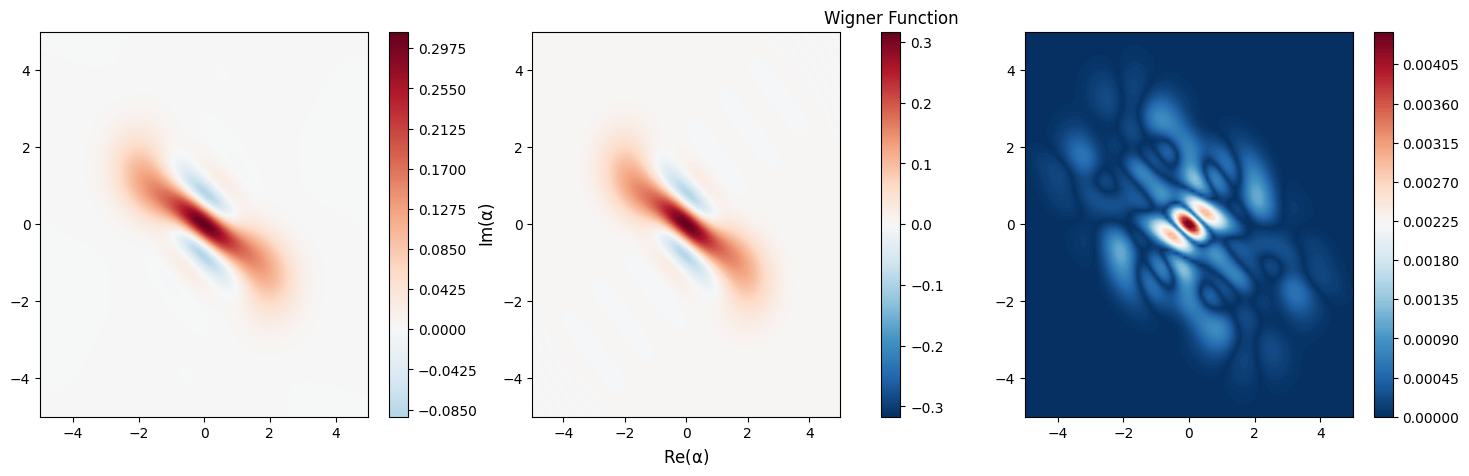

In [ ]:

sol = time_evolve(0, 0.036)

In [ ]:
time_evolution_flat = sol.ys
param_shape = (6,7)
time_evolution_params = time_evolution_flat.reshape(-1, *param_shape)
for t ,params in zip(sol.ts, time_evolution_params):
    T = geometric_tensor(params)
    V = liouvillian_gradient(params)
    print(t)
    print("V norm:", jnp.linalg.norm(V))
    eigvals, eigvecs = jla.eig(T)
    print("Min eigval:", jnp.min(jnp.real(eigvals)))    
    print("Max eigval:", jnp.max(jnp.real(eigvals)))

0.0
V norm: 1.9496295501813643
Min eigval: -3.495561187017621e-17
Max eigval: 0.026528868192103698
0.0007346938775510203
V norm: 2.088793297561203
Min eigval: -3.4736883514673417e-17
Max eigval: 0.028368142172191725
0.0014693877551020405
V norm: 2.272493123050726
Min eigval: -1.2172795332389428e-18
Max eigval: 0.031047760928157732
0.0022040816326530607
V norm: 2.520604331187635
Min eigval: -2.2478490105812768e-18
Max eigval: 0.033862813500521866
0.002938775510204081
V norm: 2.781934420313645
Min eigval: -5.234898759237761e-19
Max eigval: 0.03850174215976282
0.0036734693877551014
V norm: 3.2214082578287053
Min eigval: -2.2922541578664918e-18
Max eigval: 0.04722966623343361
0.004408163265306121
V norm: 4.215939671812256
Min eigval: -3.6207047103989546e-19
Max eigval: 0.07581764072945539
0.005142857142857142
V norm: 5.129514294038326
Min eigval: 1.6772198601116262e-18
Max eigval: 0.11270664969447583
0.005877551020408162
V norm: 5.386473885942442
Min eigval: 1.2818092388507836e-18
Max eigv

Expanding ansatz from 6 to 24 Gaussians...
0.036
V norm: 143.4148485987948
Min eigval: -1.0381978599530235e-13
Max eigval: 3818.933466675714
Plotting initial state...
Starting integration from t=0.036 to 0.15...
0.00%
t: 0.03600088888888889 | N: 1.5731303388066236 | P: 1.00916484702154
t: 0.036000177777777774 | N: 1.5730807743005046 | P: 1.009082281484468
t: 0.03600026666666666 | N: 1.5730857141176988 | P: 1.0090684719306138
t: 0.036000399999999995 | N: 1.5730930237540717 | P: 1.009092107039972
t: 0.036001 | N: 1.5731388107868403 | P: 1.0071267329095177
t: 0.036000472 | N: 1.5730964439812634 | P: 1.0090856809067814
t: 0.0360000913086268 | N: 1.5730754814169363 | P: 1.0090797231745054
t: 0.0360001369629402 | N: 1.5730780707563758 | P: 1.0090777119032146
t: 0.03600020544441031 | N: 1.573081993839633 | P: 1.0090796470146546
t: 0.03600051361102577 | N: 1.5731004213119004 | P: 1.0090946091636988
t: 0.03600061633323093 | N: 1.5731057782051863 | P: 1.009088452840011
t: 0.036000242424404166 | 

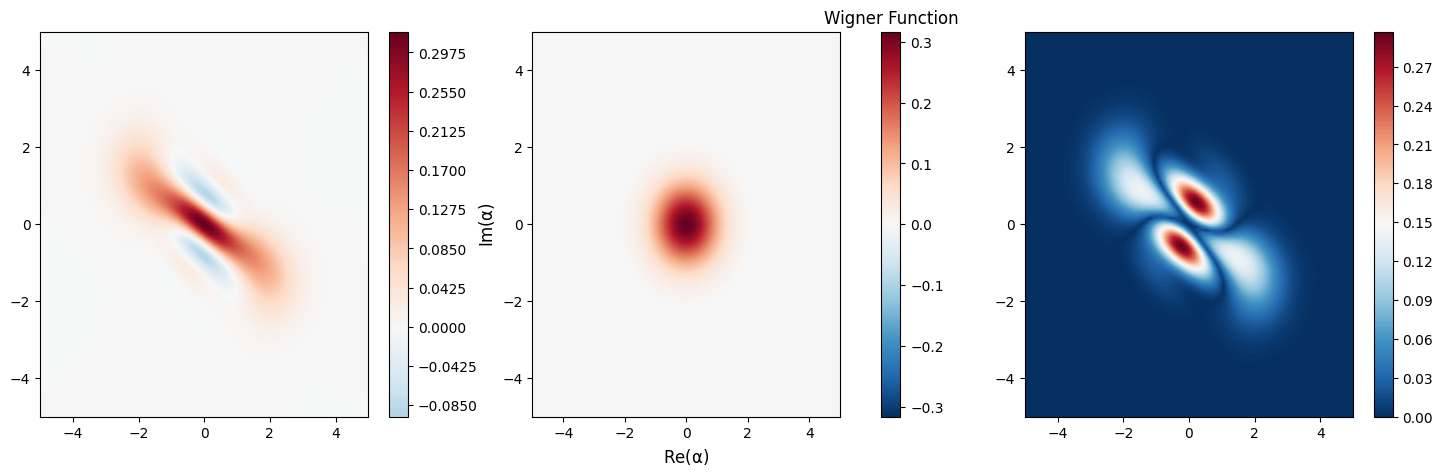

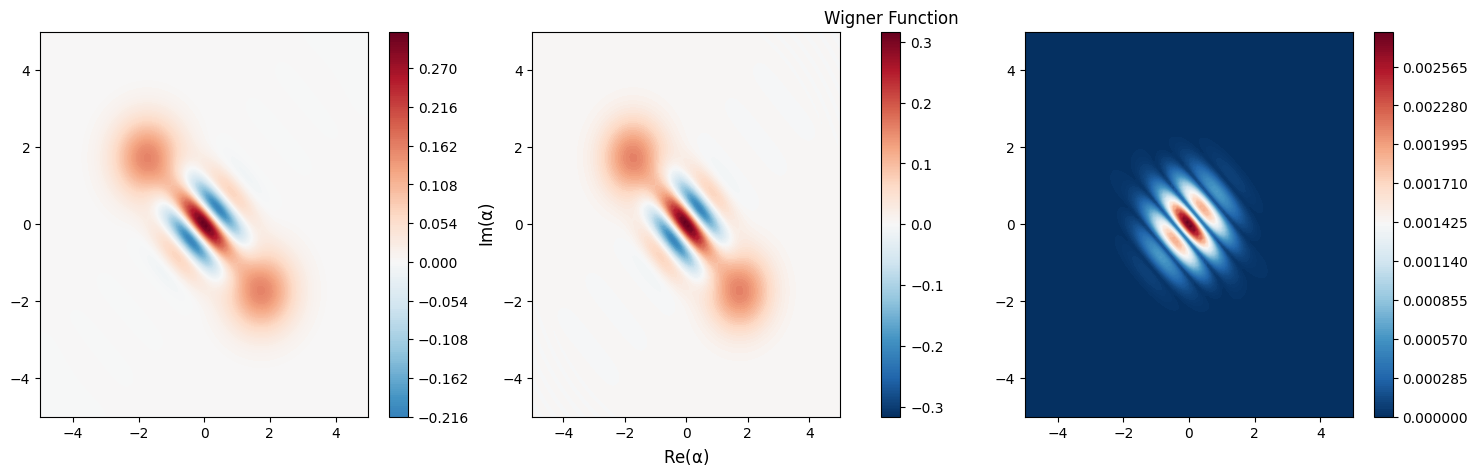

In [9]:
params = time_evolution_params[-1]
#params = params.at[1:,0].set(0)
params = expand_state_cluster(params, expansion_factor=4, noise_scale=1e-2)

T = geometric_tensor(params)
V = liouvillian_gradient(params)
print(t)
print("V norm:", jnp.linalg.norm(V))
eigvals, eigvecs = jla.eig(T)
print("Min eigval:", jnp.min(jnp.real(eigvals)))    
print("Max eigval:", jnp.max(jnp.real(eigvals)))

new_sol_24 = time_evolve(0.036, 0.15, params=params)

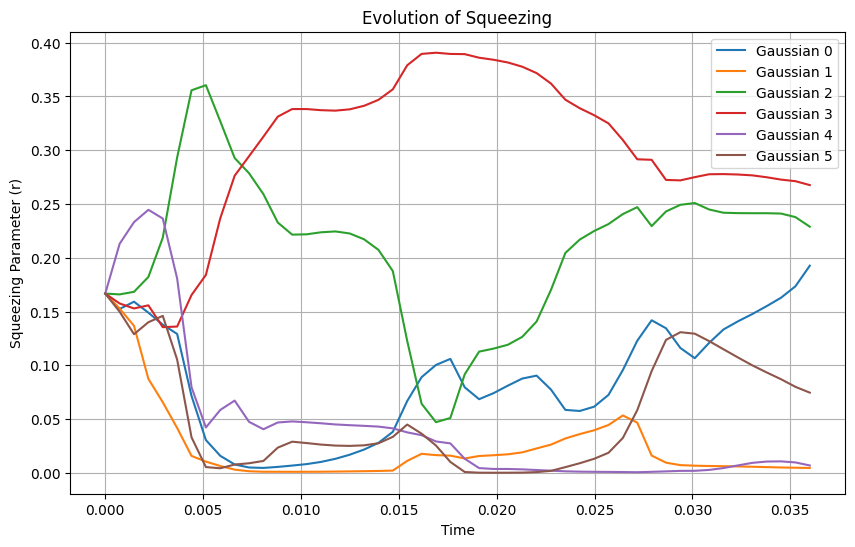

In [23]:
import matplotlib.pyplot as plt

# Reshape sol.ys: (timesteps, N_G * 7) -> (timesteps, N_G, 7)
evolution_params = sol.ys.reshape(len(sol.ts), -1, 7)

# Extract squeezing r (index 5) for all Gaussians
r_values = evolution_params[:, :, 0]

plt.figure(figsize=(10, 6))
for i in range(r_values.shape[1]):
    plt.plot(sol.ts, r_values[:, i], label=f'Gaussian {i}')

plt.xlabel('Time')
plt.ylabel('Squeezing Parameter (r)')
plt.title('Evolution of Squeezing')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import jax.numpy as jnp
import jax.numpy.linalg as jla
import jax
import jax.scipy.linalg as jsl
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
from typing import Union, Tuple, Iterator
import fractions
import itertools
import functools
import math
import numpy as np
from diffrax import diffeqsolve, Dopri8, Tsit5, ODETerm, SaveAt, PIDController
import diffrax
import optimistix as optx

import jax
import jax.numpy as jnp
from jax.experimental import jet
import qutip as qt
from scipy.integrate import solve_ivp
import time

jax.config.update("jax_enable_x64", True)

Rational = Union[int, fractions.Fraction]

# --- [Existing Math Helper Functions Remain Unchanged] ---

@functools.lru_cache(maxsize=None)
def binomial_coeff(n: Rational, k: int) -> Rational:
    if k < 0:
        raise ValueError("k must be a non-negative integer")
    n = fractions.Fraction(n)
    result = 1
    for i in range(k):
        result *= (n - i) / (i + 1)
    return result

MultiIndex = Tuple[int, ...]

def multi_index_lte(i: MultiIndex) -> Iterator[MultiIndex]:
    return itertools.islice(
        itertools.product(*(range(0, k + 1) for k in i)),
        1,
        None,
    )

@functools.lru_cache(maxsize=None)
def multi_index_binomial_coeff(i: Tuple[Rational, ...],
                               j: MultiIndex) -> Rational:
    result = 1
    for i_k, j_k in zip(i, j):
        result *= binomial_coeff(i_k, j_k)
    return result

def coeffs(i: MultiIndex) -> Iterator[Tuple[MultiIndex, Rational]]:
    for j in multi_index_lte(i):
        c = multi_index_binomial_coeff(i, j) * (-1)**(sum(i) - sum(j))
        if c != 0:
            yield j, c

@functools.lru_cache(maxsize=None)
def precompute_kc(orders: MultiIndex) -> Tuple[np.ndarray, np.ndarray]:
    ks, cs = [], []
    for k, c in coeffs(orders):
        k = np.array(list(map(float, k)))
        c = float(c)
        ks.append(list(k))
        cs.append(c)
    ks = np.array(ks)
    cs = np.array(cs)
    return ks, cs

@functools.lru_cache(maxsize=None)
def structured_orders_to_flat(
    orders: Tuple[Tuple[int, int, int], ...],
    num_modes: int,
    n_phase: int
) -> MultiIndex:
    """
    Convert [(site, phase, multiplicity), ...] to flat multi-index.
    """
    D = num_modes * n_phase
    flat = [0] * D

    for site, phase, mult in orders:
        if mult == 0:
            continue
        if site < 0 or site >= num_modes:
            raise ValueError(f"Invalid site index {site}")
        if phase < 0 or phase >= n_phase:
            raise ValueError(f"Invalid phase index {phase}")
        if mult < 0:
            raise ValueError("Multiplicity must be non-negative")

        flat[site * n_phase + phase] += mult

    return tuple(flat)


def mixed_partial(f, orders: MultiIndex):
    """
    Compute mixed partial derivative specified by flat multi-index `orders`
    using JAX jets. Works for arbitrary dimension.
    """
    d = sum(orders)
    ks, cs = precompute_kc(orders)
    dfact = math.factorial(d)

    def partial_der(x0):
        x0 = jnp.asarray(x0)

        @jax.vmap
        def jet_eval(k):
            hs = (k,) + (jnp.zeros_like(x0),) * (d - 1)
            _, (*_, res) = jet.jet(f, (x0,), (hs,))
            return res

        return jnp.sum(jet_eval(ks) * cs) / dfact

    return partial_der

def g(
    param_a,
    param_b,
    orders,
    num_modes: int = 1,
    n_phase: int = 4,
):
    """
    Evaluate mixed partial of generating_function using structured orders.

    orders = [(site, phase, multiplicity), ...]
    """

    # Zeroth-order case
    if len(orders) == 0:
        return generating_function(
            param_a,
            param_b,
            jnp.zeros(num_modes * n_phase)
        )

    # Convert to hashable tuple for caching
    orders_tup = tuple(orders)

    flat_orders = structured_orders_to_flat(
        orders_tup,
        num_modes=num_modes,
        n_phase=n_phase
    )

    g_f = partial(generating_function, param_a, param_b)

    return mixed_partial(
        g_f,
        flat_orders
    )(jnp.zeros(num_modes * n_phase))

# --- [Physical Constants and Model Definition] ---

G = 30 + 30j
delta = 0
U = 10
gamma = 0
eta = 10

def calculate_covariance(covariance_params):
    r,phi = covariance_params
    S = jnp.array([
        [jnp.cos(phi), jnp.sin(phi)],
        [jnp.sin(phi), -jnp.cos(phi)]
    ])
    Sigma = 0.5*jnp.cosh(2*r)*jnp.identity(2)-0.5*jnp.sinh(2*r)*S
    return Sigma

def covariance_sum_inv(covariance_params_a, covariance_params_b):
    ra, phia = covariance_params_a
    rb, phib = covariance_params_b
    
    denom = (1. + jnp.cosh(ra)**2 * jnp.cosh(2 * rb) + 
             jnp.cosh(2 * rb) * jnp.sinh(ra)**2 - 
             4. * jnp.cos(phia - phib) * jnp.cosh(ra) * jnp.cosh(rb) * jnp.sinh(ra) * jnp.sinh(rb))
             
    num00 = (jnp.cosh(2 * ra) + jnp.cosh(2 * rb) + 
             2. * jnp.cos(phia) * jnp.cosh(ra) * jnp.sinh(ra) + 
             2. * jnp.cos(phib) * jnp.cosh(rb) * jnp.sinh(rb))
             
    num01 = (2. * jnp.cosh(ra) * jnp.sin(phia) * jnp.sinh(ra) + 
             2. * jnp.cosh(rb) * jnp.sin(phib) * jnp.sinh(rb))
             
    num11 = (jnp.cosh(2 * ra) + jnp.cosh(2 * rb) - 
             2. * jnp.cos(phia) * jnp.cosh(ra) * jnp.sinh(ra) - 
             2. * jnp.cos(phib) * jnp.cosh(rb) * jnp.sinh(rb))
             
    return jnp.array([[num00, num01], [num01, num11]]) / denom

def unwrap_params(params):
    normalization = params[0]
    mean = params[1:5]
    covariance_params = params[5:7]
    return normalization, mean, covariance_params

def generating_function(params_a, params_b, Js):
    normalization_a, mean_a, covariance_params_a = unwrap_params(params_a)
    normalization_b, mean_b, covariance_params_b = unwrap_params(params_b)
    alpha_a, beta_a = mean_a[::2], mean_a[1::2]
    alpha_b, beta_b =  mean_b[::2], mean_b[1::2]
    J, J_tilde = Js[:Js.size//2], Js[Js.size//2:]
    
    M_modes = 1
    covariance_a = calculate_covariance(covariance_params_a)
    covariance_b = calculate_covariance(covariance_params_b)
    
    covariance_sum = covariance_a + covariance_b
    inv_sigma_sum = covariance_sum_inv(covariance_params_a, covariance_params_b)
    
    v1 = alpha_b - alpha_a - jnp.dot(covariance_a, J) - J_tilde
    inv_sigma_sum_v1 = jnp.dot(inv_sigma_sum, v1)
    
    diff_beta = beta_b - beta_a
    sum_beta = beta_b + beta_a
    inv_sigma_sum_diff_beta = jnp.dot(inv_sigma_sum, diff_beta)
    inv_sigma_sum_sum_beta = jnp.dot(inv_sigma_sum, sum_beta)

    Z1 = jnp.exp(-0.5 * jnp.dot(v1, inv_sigma_sum_v1))
    M_minus = jnp.exp(0.5 * jnp.dot(diff_beta, inv_sigma_sum_diff_beta))
    M_plus = jnp.exp(0.5 * jnp.dot(sum_beta, inv_sigma_sum_sum_beta))
    
    J_dot_beta = jnp.dot(J, beta_a)
    mix_term_minus = jnp.dot(diff_beta, inv_sigma_sum_v1)
    mix_term_plus = jnp.dot(sum_beta, inv_sigma_sum_v1)
    
    C_minus = jnp.cos(J_dot_beta - mix_term_minus)
    C_plus = jnp.cos(J_dot_beta + mix_term_plus)
    num_exponent = 0.5 * jnp.dot(J, jnp.dot(covariance_a, J)) + jnp.dot(J, alpha_a)
    
    sign, logdet = jnp.linalg.slogdet(covariance_sum)
    log_denominator = 0.5 * (2*M_modes * jnp.log(2 * jnp.pi) + logdet)
    prefactor = 0.5 * jnp.exp(num_exponent - log_denominator)
    
    return normalization_a*normalization_b*prefactor * Z1 * (M_minus * C_minus + M_plus * C_plus)

@jax.jit
def geometric_tensor(params):
    def total_gen_func(params_a, params_b):
        params_a = duplicate_with_neg_mean(params_a)
        params_b = duplicate_with_neg_mean(params_b)
        return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: generating_function(param_a, param_b, jnp.zeros((4))))(params_a))(params_b))
    return jax.jacfwd(jax.grad(total_gen_func, argnums=(1)), argnums=(0))(params, params).reshape(params.size, params.size)

def g_term(param_a, param_b):
    real_term = jnp.real(G) * (
        g(param_a, param_b, [(0,1,1), (0,2,1)]) +
        g(param_a, param_b, [(0,0,1), (0,3,1)])
    )

    imag_term = jnp.imag(G) * (
        g(param_a, param_b, [(0,0,1), (0,2,1)]) -
        g(param_a, param_b, [(0,1,1), (0,3,1)])
    )

    return real_term - imag_term


def delta_term(param_a, param_b):
    return delta * (
        g(param_a, param_b, [(0,1,1), (0,2,1)]) -
        g(param_a, param_b, [(0,0,1), (0,3,1)])
    )

def u_term(param_a, param_b):
    total = g(param_a, param_b, [(0,0,3), (0,3,1)])
    total += g(param_a, param_b, [(0,0,1), (0,1,2), (0,3,1)])
    total += -g(param_a, param_b, [(0,0,2), (0,1,1), (0,2,1)])
    total += -g(param_a, param_b, [(0,1,3), (0,2,1)])
    total += 2 * g(param_a, param_b, [(0,1,1), (0,2,1)])
    total += -2 * g(param_a, param_b, [(0,0,1), (0,3,1)])
    total += 0.25 * g(param_a, param_b, [(0,1,1), (0,2,3)])
    total += -0.25 * g(param_a, param_b, [(0,0,1), (0,3,3)])
    total += -0.25 * g(param_a, param_b, [(0,0,1), (0,2,2), (0,3,1)])
    total += 0.25 * g(param_a, param_b, [(0,1,1), (0,2,1), (0,3,2)])
    return U / 2 * total

def single_photon_loss_term(param_a, param_b):
    total = g(param_a, param_b, [(0,0,1), (0,2,1)])
    total += g(param_a, param_b, [(0,1,1), (0,3,1)])
    total += 2 * g(param_a, param_b, [])
    total += 0.5 * g(param_a, param_b, [(0,2,2)])
    total += 0.5 * g(param_a, param_b, [(0,3,2)])   
    return gamma / 2 * total

def double_photon_loss_term(param_a, param_b):
    total = 0.5 * g(param_a, param_b, [(0,0,3), (0,2,1)])
    total += 0.5 * g(param_a, param_b, [(0,0,1), (0,1,2), (0,2,1)])
    total += 0.5 * g(param_a, param_b, [(0,1,3), (0,3,1)])
    total += 0.5 * g(param_a, param_b, [(0,0,2), (0,1,1), (0,3,1)])
    total += 2 * g(param_a, param_b, [(0,0,2)])
    total += 2 * g(param_a, param_b, [(0,1,2)])
    total += g(param_a, param_b, [(0,0,1), (0,2,1)])
    total += g(param_a, param_b, [(0,1,1), (0,3,1)])
    total += 0.5 * g(param_a, param_b, [(0,0,2), (0,2,2)])
    total += 0.5 * g(param_a, param_b, [(0,0,2), (0,3,2)])
    total += 0.5 * g(param_a, param_b, [(0,1,2), (0,2,2)])
    total += 0.5 * g(param_a, param_b, [(0,1,2), (0,3,2)])
    total += 0.125 * g(param_a, param_b, [(0,0,1), (0,2,3)])
    total += 0.125 * g(param_a, param_b, [(0,1,1), (0,3,3)])
    total += 0.125 * g(param_a, param_b, [(0,0,1), (0,2,1), (0,3,2)])
    total += 0.125 * g(param_a, param_b, [(0,1,1), (0,2,2), (0,3,1)])
    return eta * total


def all_terms(params_a, params_b):
    params_a = duplicate_with_neg_mean(params_a)
    params_b = duplicate_with_neg_mean(params_b)
    def func(param_a, param_b):
        return g_term(param_a, param_b) + delta_term(param_a, param_b) + u_term(param_a, param_b) + single_photon_loss_term(param_a, param_b) + double_photon_loss_term(param_a, param_b)
    return jnp.sum(jax.vmap(lambda param_a: jax.vmap(lambda param_b: func(param_a, param_b))(params_b))(params_a))

@jax.jit
def liouvillian_gradient(params):
    return jax.grad(all_terms, argnums=0) (params, params)

def renormalize_params(params):
    total_weight = jnp.sum(params[:, 0])
    return params.at[:, 0].set(params[:, 0]/ total_weight)

@jax.jit
def number_operator(params):
    params = duplicate_with_neg_mean(params)
    params = renormalize_params(params)
    # Vectorized helper for number operator within vmap
    def single_param_n(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2]
        return normalization*(jnp.sum(jnp.real(mean**2))+covariance[0,0]+covariance[1,1]-1)/2
    
    return jnp.sum(jax.vmap(single_param_n)(params))

@jax.jit
def parity_operator(params):
    # Vectorized helper for parity operator within vmap
    params = duplicate_with_neg_mean(params)
    params = renormalize_params(params)
    def single_param_parity(p):
        normalization, mean, covariance_params = unwrap_params(p)
        covariance = calculate_covariance(covariance_params)
        mean = mean[::2]+ 1j* mean[1::2] # Used in original, but math below uses real vector mean
        term = jnp.exp(-0.5 * jnp.dot(-mean, jnp.dot(jla.inv(covariance), -mean)))
        return jnp.pi * normalization * jnp.real(term) / jnp.sqrt((2*jnp.pi)**2 * jnp.linalg.det(covariance))

    return jnp.sum(jax.vmap(single_param_parity)(params))

def plot_wigner(params, filename, exact_state=None):
    x = jnp.linspace(-5, 5, 100)
    p = jnp.linspace(-5, 5, 100)
    X, P = jnp.meshgrid(x, p)
    W = jnp.zeros(X.shape)
    
    # We can keep the loop here as visualization is not the bottleneck
    # or vectorize it if needed, but loop is fine for plotting at start/end
    params = duplicate_with_neg_mean(params)
    params = renormalize_params(params)
    for param in params:
        normalization, mean, covariance_params = unwrap_params(param)
        covariance = calculate_covariance(covariance_params)
        det_cov = jla.det(covariance)
        inv_cov = jla.inv(covariance)
        phase_vars = jnp.array([X.flatten(), P.flatten()]).T
        mean = mean[::2]+ 1j* mean[1::2]
        diff = phase_vars - mean
        exponent = -0.5 * jnp.einsum("ij,ij->i", jnp.dot(diff, inv_cov), diff)
        exponent = exponent.reshape(X.shape)
        W += normalization/(2*jnp.pi*jnp.sqrt(det_cov)) * jnp.real(jnp.exp(exponent))
        
    norm = matplotlib.colors.Normalize(-abs(W).max(), abs(W).max())
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    cf = ax[0].contourf(X, P, W, levels=200, cmap='RdBu_r', norm=norm)
    fig.colorbar(cf, ax=ax[0])
    if exact_state is not None:
        qt.plot_wigner(exact_state, xvec=x, yvec=p, ax=ax[1], cmap='RdBu_r', colorbar=True)
        w_exact = qt.wigner(exact_state, xvec=x, yvec=p)
        cf_diff = ax[2].contourf(X, P, jnp.abs(w_exact - W), levels=200, cmap='RdBu_r')
        fig.colorbar(cf_diff, ax=ax[2])
    
    plt.title('Wigner Function')
    #plt.savefig(filename)

# --- [Initialization Functions] ---

def initialize_cat_state(alpha=1.0):
    N_G = 4
    params = jnp.zeros((N_G, 7))
    weights = jnp.ones(N_G) 
    params = params.at[:, 0].set(weights)
    params = params.at[2:, 0].set(jnp.exp(-2 * (alpha)**2))
    
    dist = jnp.sqrt(2) * alpha
    params = params.at[0, 1].set(dist)
    params = params.at[1, 1].set(-dist)
    params = params.at[2, 4].set(dist)
    params = params.at[3, 4].set(-dist)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    return params

def initialize_vacuum_state(N_G):
    params = jnp.zeros((N_G, 7))
    params = params.at[:, 0].set(1.0)
    params = params.at[:,0].divide(jnp.sum(params[:,0]))
    return params

def expand_state_cluster(params, expansion_factor=4, noise_scale=1e-4, key=None):
    if key is None:
        key = jax.random.PRNGKey(0)
    old_N = params.shape[0]
    new_N = old_N * expansion_factor
    new_params = jnp.zeros((new_N, 7))
    print(f"Expanding ansatz from {old_N} to {new_N} Gaussians...")
    for i in range(old_N):
        base_weight = params[i, 0]
        base_center = params[i, 1:5] # Fixed slicing index from original code
        base_cov = params[i, 5:7]
        key, subkey = jax.random.split(key)
        offsets = jax.random.normal(subkey, (expansion_factor, 4)) * noise_scale # Offset for 4 center coords
        start_idx = i * expansion_factor
        end_idx = start_idx + expansion_factor
        random_weight = jax.random.uniform(subkey, (expansion_factor,)) 
        new_params = new_params.at[start_idx:end_idx, 0].set(random_weight)
        new_centers = base_center + offsets
        new_params = new_params.at[start_idx:end_idx, 1:5].set(new_centers)
        new_params = new_params.at[start_idx:end_idx, 5:7].set(base_cov)
    total_weight = jnp.sum(new_params[:, 0])
    new_params = new_params.at[:, 0].divide(total_weight)
    return new_params

def duplicate_with_neg_mean(params):
    neg_params = params.at[:, 1:5].set(-params[:, 1:5])
    params = jnp.concatenate([params, neg_params], axis=0)
    params = params.at[:, 0].divide(2)
    return params

@jax.jit
def compute_update_step(t, params_flat, args):
    params = params_flat.reshape((-1,7))
    params = renormalize_params(params)
    # Calculate Gradient and Geometric Tensor
    V = liouvillian_gradient(params).flatten()
    T = geometric_tensor(params)
    # Logging for diagnostics
    def log_fn(args):
        t_val = args
        jax.debug.print(
            "t: {t_v} | N: {m} | P: {p}",
            t_v=t_val, m=number_operator(params), p=parity_operator(params)
        )

    d_params = jla.solve(T + 1e-12*jnp.eye(T.shape[0]), V)
    #d_params = jla.lstsq(T, V, rcond=1e-12)[0]
    log_condition = jnp.logical_and(jnp.mod(t, 0.001) < 1e-6, t > 1e-6)
    jax.lax.cond(
        log_condition,
        log_fn,
        lambda _: None,
        t,
    )

    return d_params.flatten()

def time_evolve(initial_time, end_time, params=None, N_G=6):
    # Simulation parameters
    N = 100            # Hilbert space cutoff (must be high enough to capture squeezing)
    steps = 100       # Higher resolution than the Euler step
    t_eval = jnp.linspace(initial_time, end_time, steps)

    # --- 2. Operators ---
    a = qt.destroy(N)
    n_op = a.dag() * a
    x_op = (a + a.dag()) / np.sqrt(2) # Position quadrature
    p_op = 1j * (a.dag() - a) / np.sqrt(2) # Momentum quadrature

    # Parity operator defined as exp(i * pi * n)
    # Equivalently, it is a diagonal matrix with entries (-1)^n
    parity_op = (1j * np.pi * n_op).expm() 

    # --- 3. Hamiltonian Construction ---
    # H_detuning = delta * a^dag * a
    H_det = -delta * n_op

    # H_kerr = (U/2) * a^dag^2 * a^2 (Standard Kerr form)
    H_kerr = 0.5 * U * a.dag()**2 * a**2

    # H_drive = G * a^dag^2 + G* * a^2 (Two-photon drive)
    # Note: In some conventions, this might be i(G a^dag^2 - G* a^2).
    # Based on your JAX summation, it implies a direct Hermitian addition:
    H_drive = (G/2 * a.dag()**2) + (np.conj(G)/2 * a**2)

    # Total Hamiltonian
    # To simulate the "Only G term" case, set delta=0 and U=0 here.
    H = H_drive + H_det + H_kerr

    # --- 4. Dissipation ---
    # Single photon loss: sqrt(gamma) * a
    c_ops = [np.sqrt(gamma) * a, np.sqrt(eta) * a**2]

    # --- 5. Initial State ---
    # Vacuum state
    psi0 = (qt.coherent(N, 2) + qt.coherent(N, -2)).unit()
    psi0 = qt.basis(N, 0)

    # --- 6. Solve Master Equation ---
    result = qt.mesolve(H, psi0, t_eval, c_ops, e_ops=[x_op, p_op, n_op, parity_op], options={"store_final_state":True})

    # --- 7. Plotting & Verification ---
    means_x = result.expect[0]
    means_p = result.expect[1]
    means_n = result.expect[2]
    means_parity = result.expect[3]
    #params = initialize_cat_state(alpha=2)
    if params is None:
        params = initialize_vacuum_state(N_G=1)
        params = expand_state_cluster(params, expansion_factor=N_G, noise_scale=1e-2)
    param_shape = params.shape
    
    # Initial Plot
    print("Plotting initial state...")
    plot_wigner(params, "initial_state.png", exact_state=psi0)

    
    print(f"Starting integration from t={initial_time} to {end_time}...")
    term = ODETerm(compute_update_step)
    solver = diffrax.Dopri8()
    saveat = SaveAt(ts=t_eval)

    stepsize_controller = PIDController(rtol=1e-3, atol=1e-6)

    progress_meter = diffrax.TextProgressMeter()
    sol = diffeqsolve(term, solver, t0=initial_time, t1=end_time, dt0=None, y0=params.flatten(), saveat=saveat,
                    stepsize_controller=stepsize_controller, max_steps=None, progress_meter=progress_meter)
        
    print("Integration complete. Computing observables...")
    print(sol.stats)

    # 5. Post-process Observables using JAX Vmap (Much faster than looping)
    # sol.y shape is (num_params, num_timesteps). Transpose to (num_timesteps, num_params)
    time_evolution_flat = sol.ys
    # Reshape to (num_timesteps, N_G, 8)
    time_evolution_params = time_evolution_flat.reshape(-1, *param_shape)
    
    # Vectorize observable functions over the time axis
    compute_all_n = jax.vmap(number_operator)
    compute_all_parity = jax.vmap(parity_operator)
    
    ns = compute_all_n(time_evolution_params)
    parities = compute_all_parity(time_evolution_params)

    print("Initial:", ns[0], parities[0])
    
    # 6. Final Plot and Analysis
    final_params = time_evolution_params[-1]
    #final_params = renormalize_params(final_params)

    plot_wigner(final_params, "final_state.png", exact_state=result.final_state)
    print(result)
    print("Final Time:", t_eval[-1])
    print("Final Params:\n", final_params)
    print("Final Number Operator:", ns[-1])
    print("Final Parity Operator:", parities[-1])

    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    # Plot Observables
    ax[0].plot(t_eval, ns, label='Number Operator')
    ax[0].plot(t_eval, means_n, '--') 
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('<n>')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(t_eval, parities, label='Parity')
    ax[1].plot(t_eval, means_parity, '--')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Parity')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()
    return sol


Expanding ansatz from 1 to 16 Gaussians...
Plotting initial state...
Starting integration from t=0 to 0.5...
0.00%
t: 0.01 | N: nan | P: nan
t: 0.01 | N: nan | P: nan
t: 0.01 | N: nan | P: nan
t: 0.002 | N: nan | P: nan
t: 0.002 | N: nan | P: nan
t: 0.002 | N: nan | P: nan
2.02%
t: 0.012000674576214641 | N: 0.23915623328964392 | P: 1.0000056884637938
4.10%
6.11%
8.25%
t: 0.049000376598111475 | N: 2.224718409384425 | P: 0.9999425410674689
10.43%
t: 0.053000184758234176 | N: 2.375413438986945 | P: 0.9995764876284454
12.46%
t: 0.06500084738061926 | N: 2.6944039231549035 | P: 0.9999326234098636
t: 0.06500084738061926 | N: 2.694407943031434 | P: 0.999930222951229
t: 0.06500084738061926 | N: 2.694401930973263 | P: 0.9999336518520989
14.48%
16.51%
t: 0.09000023935289009 | N: 2.935856726127773 | P: 0.9999297583803637
t: 0.09100035097597133 | N: 2.9390040565255378 | P: 0.9999153623169086
18.54%
t: 0.1010000050614674 | N: 2.9583087115604165 | P: 0.999925793966332
20.57%
t: 0.1030005029679885 | N

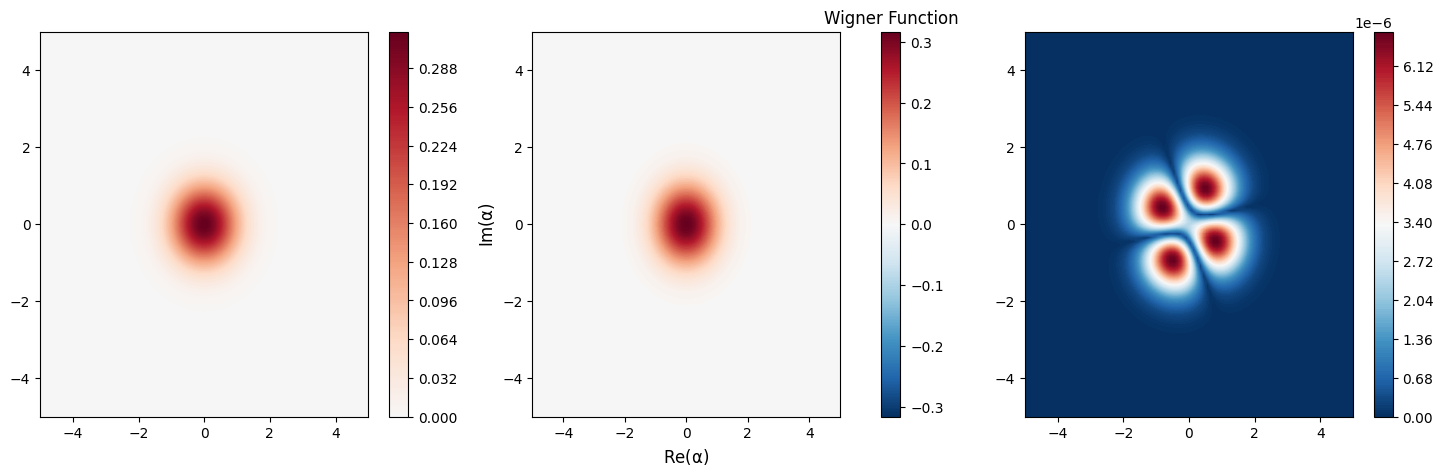

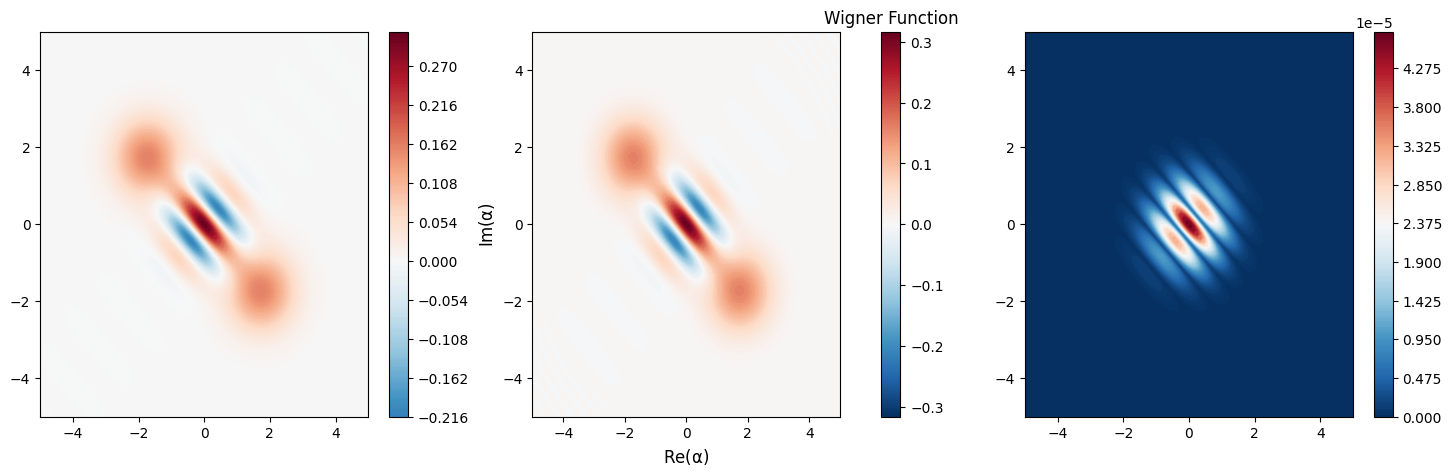

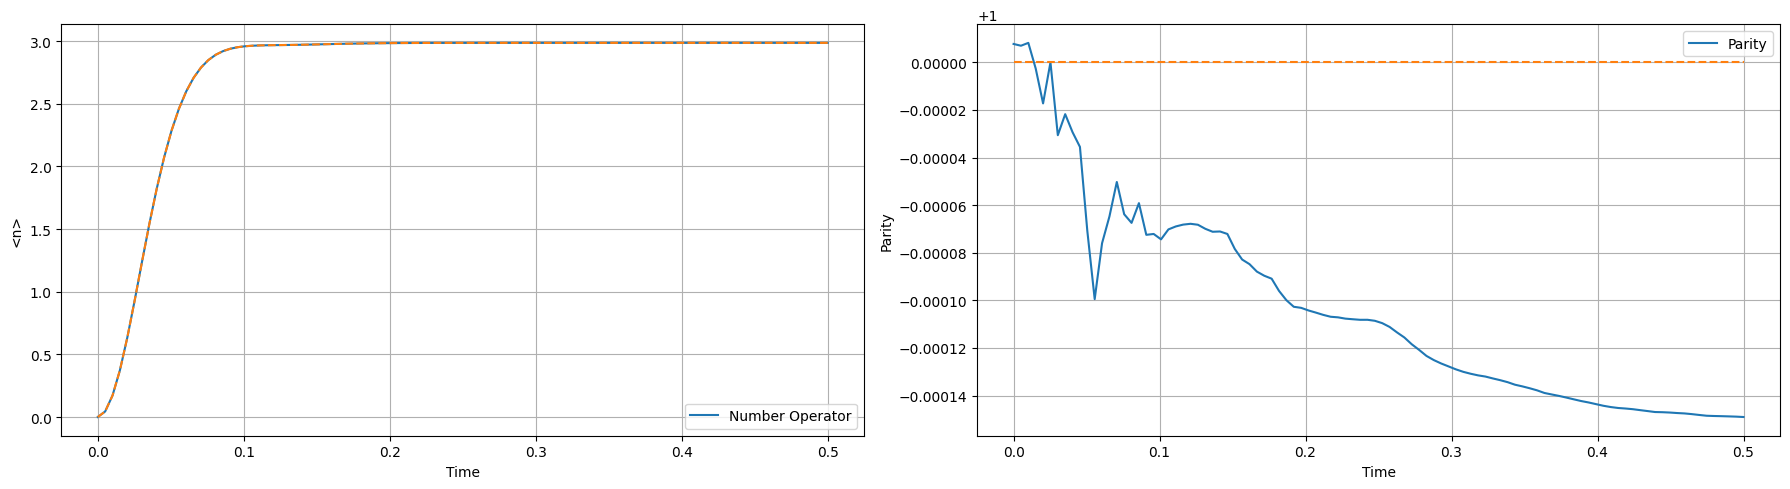

In [19]:
sol = time_evolve(0, 0.5, N_G=16)

In [17]:
print(sol.ys[-1].reshape((-1,7))[0])
term_diff(sol.ys[-1].reshape((-1,7))[0])
print()
term_diff(initialize_vacuum_state(1)[0])

[-0.01780435 -0.00968987  0.04985686  0.00392903  0.08082423 -0.35986321
 -0.25638278]
0.0
0.0
0.0
0.0
1.5013658990082474e-18
1.5013658990082474e-18
-0.0
-0.0
-2.0395813389523918e-05
-2.0395813389523918e-05

6.245004513516506e-16
6.245004513516506e-16
0.0
0.0
9.251858538542975e-17
9.251858538542975e-17
0.0
0.0
1.4051260155412137e-15
1.4051260155412137e-15
